## 1. Importing required packages

The following cell needs to be run first whenever the kernel is restarted.

In [3]:
from geocube.vector import vectorize

import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import pandas as pd

import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
from rasterio.features import rasterize
from rasterio.transform import from_origin

import rioxarray

from rtree import index

from scipy.optimize import curve_fit

from shapely.ops import nearest_points
from shapely.geometry import box

from sklearn.metrics import r2_score

import mapclassify

## 2. Population data

### 2.1 Vectorising population raster and storing it as a GeoDataFrame

In [19]:
# opening and saving raster population data
pop_raster = rioxarray.open_rasterio('NAM_GHS_popcount_2015_30arcsec.tif').squeeze().astype('float32')

# naming raster layer data, corresponds to column name upon vectorisation
pop_raster.name = '2015_POP'

# vectorising and saving population data
pop_gdf = vectorize(pop_raster)

### 2.2 Filtering out cells with less than 1 capita/km2

The purpose of this step is to remove noise from the original population dataset by filtering out cells with extremely low population density, i.e. less than 1 capita/km2. This threshold can be adjusted or this step could be skipped entirely if the resulting population total is significantly different from the original dataset. However, it is advised to at least round population count per cell to the nearest whole number to avoid distortion in later calculations, like GDP per capita.

In [20]:
# checking initial cell and population counts
n_cells = len(pop_gdf) # number of populated cells
tot_pop = pop_gdf['2015_POP'].sum() # population total
print('total number of cells: ', n_cells)
print('total population: ', f'{tot_pop:.0f}')

# creating new gdf including only cells with at least 1 cap/km2
pop_gdf_gt1 = pop_gdf[pop_gdf['2015_POP'] >= 1]
n_cells_gt1 = len(pop_gdf_gt1) # number of cells after filtering
tot_pop_gt1 = pop_gdf_gt1['2015_POP'].sum() # total population after filtering
print('number of cells with at least 1 cap/km2: ', n_cells_gt1)
print('total population (>= 1 cap/km2): ', f'{tot_pop_gt1:.0f}')

# checking filtered cell and population counts compared to original dataset
print('cell ratio: ', f'{n_cells_gt1 / n_cells * 100:.1f} %')
print('population ratio: ', f'{tot_pop_gt1 / tot_pop * 100:.1f} %')

pop_gdf_gt1.sort_values('2015_POP').head()

total number of cells:  118564
total population:  2286112
number of cells with at least 1 cap/km2:  63986
total population (>= 1 cap/km2):  2272843
cell ratio:  54.0 %
population ratio:  99.4 %


,2015_POP,geometry
59269,1.000087,"POLYGON ((16.35875 -19.55042, 16.35875 -19.558..."
81212,1.000174,"POLYGON ((16.90875 -21.95042, 16.90875 -21.958..."
33803,1.000179,"POLYGON ((23.39208 -18.00042, 23.39208 -18.008..."
70005,1.000242,"POLYGON ((17.03375 -20.73375, 17.03375 -20.742..."
107153,1.000283,"POLYGON ((18.31708 -25.39208, 18.31708 -25.400..."


## 3. Electrification status

### 3.1 Importing and preparing nighttime lights raster layer

This step includes importing the original nighttime lights layer, downsampling it to match the resolution of the population and GDP datasets, and aligning it to the population dataset to ensure compatibility.

In [21]:
# Downsampling nighttime lights raster layer to match the resolution of population and GDP layers, from 15 arcsec to 30 arcsec

# input and output raster files paths
# insert file name and extension if file is already uploaded to the same workspace, otherwise insert full file path
# it is recommended to upload a copy of all required raw files to the active workspace
input_raster_path = 'nam_nighttime_lights_2022.tif' # source file
output_raster_path = 'nam_nighttime_lights_2022_30arcsec.tif' # destination file

# opening the input raster file
with rasterio.open(input_raster_path) as src:
    # reading the metadata of the input raster
    src_transform = src.transform
    src_crs = src.crs
    src_width = src.width
    src_height = src.height
    src_count = src.count

    # defining the downsampling factor
    downsampling_factor = 30 / 15 # target resolution/original resolution in CRS units

    # calculating the new dimensions based on downsampling factor
    dst_width = src_width // downsampling_factor
    dst_height = src_height // downsampling_factor

    # calculating the new transformation
    dst_transform = src_transform * src_transform.scale(
        (src_width / dst_width),
        (src_height / dst_height)
    )

    # defining the metadata of the output raster
    dst_meta = src.meta.copy()
    dst_meta.update({
        'width': dst_width,
        'height': dst_height,
        'transform': dst_transform,
        'nodata': 0
    })

    # opening the output raster file
    with rasterio.open(output_raster_path, 'w', **dst_meta) as dst:
        # looping over all bands and resampling each as required
        # the resampling method used here is "max"
        # other resampling methods can be applied, like nearest, bilinear, etc.
        for i in range(1, src_count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src_transform,
                src_crs=src_crs,
                dst_transform=dst_transform,
                dst_crs=src_crs,
                resampling=Resampling.max
            )

# printing downsampling confirmation
print(f"Downsampled raster saved to '{output_raster_path}'")

Downsampled raster saved to 'nam_nighttime_lights_2022_30arcsec.tif'


In [22]:
# Defining a new function for raster alignment
def align_raster_to_reference(src_path, target_path, dst_path, band_to_align=1):
    """
    Aligns a source raster to a target raster's grid and saves the result.

    Parameters:
    src_path (str): Path to the source raster that needs alignment.
    target_path (str): Path to the target raster to use as alignment reference.
    dst_path (str): Path to save the aligned raster.
    band_to_align (int): The band number in the source raster to align. Default is 1.
    """
    # opening source raster (needs alignment)
    with rasterio.open(src_path) as src:
        src_transform = src.transform
        src_band_names = src.descriptions

        # opening target raster (alignment reference)
        with rasterio.open(target_path) as target:
            dst_crs = target.crs

            # calculating the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,    # source CRS
                dst_crs,    # target CRS
                target.width,   # target width
                target.height,  # target height 
                *target.bounds, # unpacks target outer boundaries (left, bottom, right, top)
            )

        # setting the properties for the output raster
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({'crs': dst_crs,
                           'transform': dst_transform,
                           'width': dst_width,
                           'height': dst_height,
                           'nodata': 0,
                           'count': 1}) # generate a single band raster file for the base year

        # printing the affine transformation to be used
        print("Coregistered to shape:", dst_height, dst_width, '\n Affine', dst_transform)

        # opening output raster (to which results will be saved)
        with rasterio.open(dst_path, 'w', **dst_kwargs) as dst:
            # reprojecting the source file
            reproject(
                source=rasterio.band(src, band_to_align), # only the specified band
                destination=rasterio.band(dst, 1), # write data to the first and only band of the output file
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest) # resampling method can be changed based on needs
        
        # printing raster alignment confirmation
        print(f"Aligned raster saved to '{dst_path}'")

In [23]:
# Aligning nighttime lights layer to population layer to ensure consistency before sampling
align_raster_to_reference('nam_nighttime_lights_2022_30arcsec.tif', 'NAM_GHS_popcount_2015_30arcsec.tif',
                          'nam_nighttime_lights_2022_aligned.tif', 1)

Coregistered to shape: 1440 1623 
 Affine | 0.01, 0.00, 11.74|
| 0.00,-0.01,-16.97|
| 0.00, 0.00, 1.00|
Aligned raster saved to 'nam_nighttime_lights_2022_aligned.tif'


### 3.2 Determining electrification status of each populated cell

After the nighttime lights layer has been prepared for compatibility, it can be used to determine the initial electrification status of each populated cell. This step involves sampling the nighttime lights value corresponding to each populated cell. The minimum threshold of nighttime lights required to classify a populated cell as electrified is then iteratively calibrated such that the share of electrified population matches national statistics.

In [24]:
# Defining a new function for raster sampling
def r_sample(raster_path, band, gdf, col_name):
    '''
    This function samples values from a raster layer corresponding to geometry centroids of a polygon GeoDataFrame.
    Inputs:
        raster_path (str): name/full path of raster file from which data will be sampled
        band (int): number of raster band from which values should be sampled
        gdf (var): variable name of the GeoDataFrame containing polygon geometries for which data needs to be sampled
        col_name (str): name to be given to the column containing sampled values in the GeoDataFrame
    Returns:
        Input GeoDataFrame with newly added column containing sampled values.
    '''
    # opening nad reading data from the source raster file
    with rasterio.open(raster_path) as src:
        raster_data = src.read(band)
        raster_transform = src.transform
        raster_nodata = src.nodata

        # calculating centroids of the GeoDataFrame polygon geometries
        gdf['centroid'] = gdf.geometry.centroid

        # extracting raster values using polygon centroids
        centroid_coords = [(x, y) for x, y in zip(gdf['centroid'].x, gdf['centroid'].y)]
        raster_values = [val[0] for val in src.sample(centroid_coords, indexes=band)]

        # adding sampled raster values to the GeoDataFrame as a new column
        gdf[col_name] = raster_values
        return gdf

In [25]:
# Sampling nighttime lights layer for each populated cell
pop_ntl_gdf = r_sample('nam_nighttime_lights_2022_aligned.tif', 1, pop_gdf_gt1, '2022_NTL')
pop_ntl_gdf.head()

,2015_POP,geometry,centroid,2022_NTL
2,24.127243,"POLYGON ((13.37542 -16.97542, 13.37542 -16.983...",POINT (13.37958 -16.97958),0.0
3,1.094425,"POLYGON ((13.35875 -16.98375, 13.35875 -16.992...",POINT (13.36292 -16.98792),0.0
4,5.762102,"POLYGON ((13.36708 -16.98375, 13.36708 -16.992...",POINT (13.37125 -16.98792),0.0
5,150.858566,"POLYGON ((13.37542 -16.98375, 13.37542 -16.992...",POINT (13.37958 -16.98792),0.0
6,38.879845,"POLYGON ((13.38375 -16.98375, 13.38375 -16.992...",POINT (13.38792 -16.98792),0.0


In [27]:
# Official electrification statistics
# from World Bank: https://data.worldbank.org/indicator/EG.ELC.ACCS.ZS?locations=NA
# change based on study region
elec_access_2022 = 0.562

# total population, both electrified and unelectrified
tot_pop = pop_ntl_gdf['2015_POP'].sum()

# calibrating nighttime lights threshold to official electricity access rate to determine electrification status of each populated cell
init_threshold = 0 # initial nighttime lights min. threshold
tol = 0.05 / 100 # error tolerance in %

# classifying populated cells based on initial nighttime lights threshold
pop_ntl_gdf['elec_stat'] = np.where(pop_ntl_gdf['2022_NTL'] > init_threshold, True, False)

# calculating initial electrification share from total population
elec_access_calc = pop_ntl_gdf.loc[pop_ntl_gdf['elec_stat'] == True, '2015_POP'].sum() / tot_pop
# calculating absolute error between initial calculation and official stats
abs_err = elec_access_calc - elec_access_2022

# calibrating nighttime lights threshold based on defined error tolerance
# case 1: too few electrified cells based on initial threshold
if abs_err < 0:
    print('Calculated electricity access rate: ', f'{(elec_access_calc * 100):.3f}', '%')
    print('Current nighttime lights threshold: ', init_threshold)
    print('Absolute error: ', f'{(abs_err * 100):.2f}', '%')
    print('Starting electricity access rate is below official figures, try adjusting the initial threshold to a lower value.')

# case 2: acceptable electrification share based on initial threshold
elif abs_err <= tol:
    print('Calculated electricity access rate: ', f'{(elec_access_calc * 100):.3f}', '%')
    print('Current nighttime lights threshold: ', init_threshold)
    print('Absolute error: ', f'{(abs_err * 100):.2f}', '%')
    print('Resulting electricity access rate is within an acceptable error margin.')

# case 3: too many electrified cells based on initial threshold
else:
    adj = 0.5 # threshold adjustment step, can be changed
    adj_threshold = init_threshold + adj
    
    for i in range(1,50): # limited to 50 iterations, can be changed
        # re-calculating electrification share based on adjusted threshold
        pop_ntl_gdf['elec_stat'] = np.where(pop_ntl_gdf['2022_NTL'] > adj_threshold, True, False) # re-classify
        elec_access_calc = pop_ntl_gdf.loc[pop_ntl_gdf['elec_stat'] == True, '2015_POP'].sum() / tot_pop # re-calculate share
        abs_err = elec_access_calc - elec_access_2022 # re-calculate error
        
        if abs_err < 0: # case 1
            adj = adj/2
            adj_threshold -= adj
        elif abs_err > tol: # case 3
            adj_threshold += adj
        else: # case 2
            break
    
    # final calculations after satisfying defined error tolerance or reaching 50 iterations 
    print('Calculated electricity access rate: ', f'{(elec_access_calc * 100):.3f}', '%')
    print('Current nighttime lights threshold: ', adj_threshold)
    print('Absolute error: ', f'{(abs_err * 100):.2f}', '%')
    
    if abs_err <= tol:
        print('Resulting electricity access rate is within an acceptable error margin.')
    else:
        print('Error in electricity access rate is unacceptable, try adjusting the initial threshold.')     

Calculated electricity access rate:  56.216 %
Current nighttime lights threshold:  0.556640625
Absolute error:  0.02 %
Resulting electricity access rate is within an acceptable error margin.


In [28]:
pop_ntl_gdf.sort_values('elec_stat').tail()

,2015_POP,geometry,centroid,2022_NTL,elec_stat
87067,2.993887,"POLYGON ((17.20042 -22.53375, 17.20042 -22.542...",POINT (17.20458 -22.53792),0.670152,True
87066,91.641884,"POLYGON ((17.19208 -22.53375, 17.19208 -22.542...",POINT (17.19625 -22.53792),1.301407,True
87065,6.324938,"POLYGON ((17.18375 -22.53375, 17.18375 -22.542...",POINT (17.18792 -22.53792),1.301407,True
87105,9.515523,"POLYGON ((19.06708 -22.53375, 19.06708 -22.542...",POINT (19.07125 -22.53792),1.434461,True
37714,22.728899,"POLYGON ((24.02542 -18.06708, 24.02542 -18.075...",POINT (24.02958 -18.07125),0.930598,True


## 4. Base year socio-economic indicators

This part involves various steps.
First, total GDP data is obtained for each populated cell via raster sampling. However, some populated cells may not have corresponding GDP data. Thus, the population dataset is split into two; one for cells with available GDP data, and the other for cells with no available GDP data.
For the first subset, the income level (i.e. GDP per capita) is calculated for each cell via dividing cell GDP by cell population.
For the second subset, the income level is estimated based on the income level of the nearest cell with the same electrification status and available GDP data.

### 4.1 Obtaining GDP PPP data for each populated cell via raster sampling

In [33]:
# aligning GDP raster to poulation raster to ensure consistency
align_raster_to_reference('nam_GDP_PPP_2015_30arcsec.tif', 'NAM_GHS_popcount_2015_30arcsec.tif',
                          'nam_GDP_PPP_2015_1km_aligned.tif')

Coregistered to shape: 1440 1623 
 Affine | 0.01, 0.00, 11.74|
| 0.00,-0.01,-16.97|
| 0.00, 0.00, 1.00|
Aligned raster saved to 'nam_GDP_PPP_2015_1km_aligned.tif'


In [34]:
# sampling GDP values for each populated cell
pop_gdp_gdf = r_sample('nam_GDP_PPP_2015_1km_aligned.tif', 1, pop_ntl_gdf, '2015_GDP')
pop_gdp_gdf.head()

,2015_POP,geometry,centroid,2022_NTL,elec_stat,2015_GDP
2,24.127243,"POLYGON ((13.37542 -16.97542, 13.37542 -16.983...",POINT (13.37958 -16.97958),0.0,False,4026.429688
3,1.094425,"POLYGON ((13.35875 -16.98375, 13.35875 -16.992...",POINT (13.36292 -16.98792),0.0,False,0.000000
4,5.762102,"POLYGON ((13.36708 -16.98375, 13.36708 -16.992...",POINT (13.37125 -16.98792),0.0,False,45553.882812
5,150.858566,"POLYGON ((13.37542 -16.98375, 13.37542 -16.992...",POINT (13.37958 -16.98792),0.0,False,164767.359375
6,38.879845,"POLYGON ((13.38375 -16.98375, 13.38375 -16.992...",POINT (13.38792 -16.98792),0.0,False,164767.359375


### 4.2 Splitting population and GDP GeoDataFrame based on GDP data availability and electrification status

In [35]:
# GeoDataFrame of populated cells with available GDP data
pop_gdp_data_gdf = pop_gdp_gdf[pop_gdp_gdf['2015_GDP'] > 0]
print('Population with available GDP data: ', pop_gdp_data_gdf['2015_POP'].sum())

# Further splitting by electrification status
elec_pop_gdp_data_gdf = pop_gdp_data_gdf[pop_gdp_data_gdf['elec_stat'] == True]
unelec_pop_gdp_data_gdf = pop_gdp_data_gdf[pop_gdp_data_gdf['elec_stat'] == False]

# GeoDataFrame of populated cells with no available GDP data
pop_gdp_nodata_gdf = pop_gdp_gdf[pop_gdp_gdf['2015_GDP'] == 0]
print('Population with no available GDP data: ', pop_gdp_nodata_gdf['2015_POP'].sum())

# Further splitting by electrification status
elec_pop_gdp_nodata_gdf = pop_gdp_nodata_gdf[pop_gdp_nodata_gdf['elec_stat'] == True]
unelec_pop_gdp_nodata_gdf = pop_gdp_nodata_gdf[pop_gdp_nodata_gdf['elec_stat'] == False]

# Double-check that split GDFs match total length of the original one
print('length of full GDF: ', len(pop_gdp_gdf))
print('combined length of the two split GDFs: ', len(pop_gdp_data_gdf) + len(pop_gdp_nodata_gdf))
print('combined length of the four split GDFs: ', 
      len(elec_pop_gdp_data_gdf) + len(unelec_pop_gdp_data_gdf) + len(elec_pop_gdp_nodata_gdf) + len(unelec_pop_gdp_nodata_gdf))

Population with available GDP data:  1812138.6859853268
Population with no available GDP data:  460704.0526508093
length of full GDF:  63986
combined length of the two split GDFs:  63986
combined length of the four split GDFs:  63986


### 4.3 Calculating GDP per capita for populated cells with available GDP data

In [36]:
# GDP per capita is referred to as income level, abbv. INC
# calculating income level of electrified cells for base year
elec_pop_gdp_data_gdf['2015_INC'] = elec_pop_gdp_data_gdf['2015_GDP'] / elec_pop_gdp_data_gdf['2015_POP']

# checking general statistics for computed income level for electrified cells
elec_max_inc = elec_pop_gdp_data_gdf['2015_INC'].max()
elec_min_inc = elec_pop_gdp_data_gdf['2015_INC'].min()
elec_avg_inc = elec_pop_gdp_data_gdf['2015_INC'].mean()
elec_w_avg_inc = elec_pop_gdp_data_gdf['2015_GDP'].sum() / elec_pop_gdp_data_gdf['2015_POP'].sum()
print('Max. income level of electrified population: ', f'{elec_max_inc:.0f}')
print('Min. income level of electrified population: ', f'{elec_min_inc:.2f}')
print('Avg. income level of electrified population: ', f'{elec_avg_inc:.0f}') # not weighted
print('Weighted avg. income level of electrified population: ', f'{elec_w_avg_inc:.0f}')

# calculating income level of un-electrified cells for base year
unelec_pop_gdp_data_gdf['2015_INC'] = unelec_pop_gdp_data_gdf['2015_GDP'] / unelec_pop_gdp_data_gdf['2015_POP']

# checking general statistics for computed income level for un-electrified cells
unelec_max_inc = unelec_pop_gdp_data_gdf['2015_INC'].max()
unelec_min_inc = unelec_pop_gdp_data_gdf['2015_INC'].min()
unelec_avg_inc = unelec_pop_gdp_data_gdf['2015_INC'].mean()
unelec_w_avg_inc = unelec_pop_gdp_data_gdf['2015_GDP'].sum() / elec_pop_gdp_data_gdf['2015_POP'].sum()
print('Max. income level of unelectrified population: ', f'{unelec_max_inc:.0f}')
print('Min. income level of unelectrified population: ', f'{unelec_min_inc:.2f}')
print('Avg. income level of unelectrified population: ', f'{unelec_avg_inc:.0f}')
print('Weighted avg. income level of unelectrified population: ', f'{unelec_w_avg_inc:.0f}')

# printing disclaimer about currency unit, change as needed
print('All values are in constant international 2011 USD according to GDP data source.')


Max. income level of electrified population:  4927311
Min. income level of electrified population:  0.40
Avg. income level of electrified population:  18968
Weighted avg. income level of electrified population:  4234
Max. income level of unelectrified population:  2226249
Min. income level of unelectrified population:  0.26
Avg. income level of unelectrified population:  11595
Weighted avg. income level of unelectrified population:  3509
All values are in constant international 2011 USD according to GDP data source.


### 4.4 Estimating GDP per capita for populated cells with no data based on nearest neighbour

In [37]:
# Defining a new function for determining the nearest neighbour between two datasets
def nearest_inc(nodata_gdf, data_gdf):
    '''
    This function estimates income level for populated cells with no available GDP data based on the nearest neighbour from another dataset of populated cells with available GDP data.
    Inputs:
        nodata_gdf (var): GeoDataFrame of populated cells with no available GDP data
        data_gdf (var): GeoDataFrame of populated cells with available GDP data to look for nearest neighbours in
    Returns:
        nodata_gdf with two new columns; nearest neighbour index from data_gdf and corresponding estimated income level
    '''
    # ensuring both GeoDataFrames have the same CRS
    nodata_gdf = nodata_gdf.to_crs("EPSG:4326")
    data_gdf = data_gdf.to_crs("EPSG:4326")

    # creating a spatial index for data_gdf
    spatial_index = index.Index()
    for idx, geometry in data_gdf.geometry.items():
        spatial_index.insert(idx, geometry.bounds)

    # sub-function to find the spatial index of the nearest neighbor
    def find_nearest(geom):
        nearest_idx = list(spatial_index.nearest(geom.bounds, 1))[0]
        return nearest_idx

    # applying the nearest neighbor sub-function
    # adds a new column with the spatial index of the nearest neighbour with available data
    nodata_gdf['nearest_index'] = nodata_gdf.geometry.apply(find_nearest)

    # joining the data from data_gdf to nodata_gdf based on the nearest_index
    nodata_gdf = nodata_gdf.join(data_gdf, on='nearest_index', rsuffix='_nearest')
    
    # dropping extra columns
    # may need to be changed if column labels change
    nodata_gdf.drop(columns=['2015_POP_nearest', '2022_NTL_nearest', 'elec_stat_nearest', 'geometry_nearest',
                             'centroid_nearest', '2015_GDP_nearest'], inplace=True)
    
    # returning nodata_gdf with added nearest neighbour estimates
    return nodata_gdf


In [38]:
# finding nearest neighbors and joining data for electrified population
elec_pop_gdp_estimate_gdf = nearest_inc(elec_pop_gdp_nodata_gdf, elec_pop_gdp_data_gdf)

# finding nearest neighbors and joining data for un-electrified population
unelec_pop_gdp_estimate_gdf = nearest_inc(unelec_pop_gdp_nodata_gdf, unelec_pop_gdp_data_gdf)

# displaying the updated GeoDataFrame
elec_pop_gdp_estimate_gdf.head()

,2015_POP,geometry,centroid,2022_NTL,elec_stat,2015_GDP,nearest_index,2015_INC
662,51.684467,"POLYGON ((15.23375 -17.39208, 15.23375 -17.400...",POINT (15.23792 -17.39625),1.199833,True,0.0,663,4995.831419
736,100.707832,"POLYGON ((15.85875 -17.39208, 15.85875 -17.400...",POINT (15.86292 -17.39625),1.180627,True,0.0,1121,12202.803615
737,80.778961,"POLYGON ((15.86708 -17.39208, 15.86708 -17.400...",POINT (15.87125 -17.39625),4.533759,True,0.0,1121,12202.803615
738,123.962631,"POLYGON ((15.87542 -17.39208, 15.87542 -17.400...",POINT (15.87958 -17.39625),5.556441,True,0.0,1122,16622.048476
746,63.251156,"POLYGON ((15.94208 -17.39208, 15.94208 -17.400...",POINT (15.94625 -17.39625),0.600919,True,0.0,1130,358.919742


### 4.5 Re-combining GeoDataFrames and normalising population counts and income levels

In [40]:
# appending the four GeoDataframes
pop_gdp_append = pd.concat([elec_pop_gdp_data_gdf,
                            elec_pop_gdp_estimate_gdf.drop(columns=['nearest_index']),
                            unelec_pop_gdp_data_gdf,
                            unelec_pop_gdp_estimate_gdf.drop(columns=['nearest_index'])])

# double-check combined GeoDataFrame length
print('length of re-combined GeoDataFrame: ', len(pop_gdp_append))
# double-check that there are no null values
print('no. of rows with NaN: ', sum(pop_gdp_append.isna().any(axis=1)))
# double-check that all cells have a retrieved or an estimated income level
print('no. of cells with no income data: ', len(pop_gdp_append[pop_gdp_append['2015_INC'] == 0]))

# normalising individual income levels to the weighted average
# normalised income levels are used to denote the distribution of income across the study region, this distribution is assumed to be maintained throughout the transition period
tot_gdp_append = sum(pop_gdp_append['2015_INC'] * pop_gdp_append['2015_POP'])
avg_inc_append = tot_gdp_append / pop_gdp_append['2015_POP'].sum()

pop_gdp_append['Norm_INC'] = pop_gdp_append['2015_INC'] / avg_inc_append

# normalising individual population counts to the total
# normalised population counts are used to denote the distribution of population across the study region, this distribution is assumed to be maintained throughout the transition period
pop_gdp_append['Norm_POP'] = pop_gdp_append['2015_POP'] / pop_gdp_append['2015_POP'].sum()

# extracting only the necessary columns for further processing for different scenarios
pop_inc_base = pop_gdp_append[['geometry', 'centroid', 'elec_stat', 'Norm_INC', 'Norm_POP']]
pop_inc_base.head()

length of re-combined GeoDataFrame:  63986
no. of rows with NaN:  0
no. of cells with no income data:  0


,geometry,centroid,elec_stat,Norm_INC,Norm_POP
496,"POLYGON ((14.21708 -17.38375, 14.21708 -17.392...",POINT (14.22125 -17.38792),True,0.014187,0.000048
497,"POLYGON ((14.22542 -17.38375, 14.22542 -17.392...",POINT (14.22958 -17.38792),True,0.116123,0.000006
543,"POLYGON ((14.21708 -17.39208, 14.21708 -17.400...",POINT (14.22125 -17.39625),True,0.020774,0.000033
607,"POLYGON ((14.77542 -17.39208, 14.77542 -17.400...",POINT (14.77958 -17.39625),True,0.328331,0.000016
608,"POLYGON ((14.78375 -17.39208, 14.78375 -17.400...",POINT (14.78792 -17.39625),True,0.158542,0.000032


## 5. Socio-economic indicators projection over the transition period

This part involves two main steps. The first step is retrieving population and total GDP projections for the study region (country) across different Shared Socioecnomic Pathway narratives. The second step is disaggregating these single-point projections over the study region using the normalised population and income level data from the previous step. Finally, the disaggregated socio-economic projections are rasterised and saved as high-resolution maps.

### 5.1 Retrieving total population and GDP projections for each Shared Socioeconomic Pathway

In [91]:
# constructing empty population and GDP projections dataframes
country = 'Namibia' # study region (country) name, change as needed
n_scenario = 5 # number of SSPs
start_year = 2025 # change as needed
end_year = 2050 # change as needed
year_int = 5 # length of each time step between start and end years, change as needed

# initialising population, GDP, and income (i.e. GDP per capita) dataframes
pop_proj = pd.DataFrame({'Year': np.arange(start_year, end_year + year_int, year_int)})
gdp_proj = pd.DataFrame({'Year': np.arange(start_year, end_year + year_int, year_int)})
inc_proj = pd.DataFrame({'Year': np.arange(start_year, end_year + year_int, year_int)})

# populating the constructed dataframes
for n in range(1, n_scenario + 1):
    name_pop = 'SSP' + str(n) + '_POP_All'
    name_gdp = 'SSP' + str(n) + '_GDP_All'
    
    # importing GDP and POP files for each SSP (2025-2100, all countries)
    locals()[name_pop] = pd.read_excel('SSP' + str(n) + '_POP_2025_2100_AllCountries.xlsx')
    locals()[name_gdp] = pd.read_excel('SSP' + str(n) + '_GDP_2025_2100_AllCountries.xlsx')
    
    # creating initial zero columns for each SSP
    col_name = 'SSP' + str(n)
    pop_proj[col_name] = 0
    gdp_proj[col_name] = 0
    
    for x in range(start_year, end_year + year_int, year_int):
        # populating each SSP column with country-specific population count and total GDP
        # original SSP datasets have population count in millions and total GDP in billions
        pop_proj.loc[pop_proj['Year'] == x, [col_name]] = (locals()[name_pop].loc[locals()[name_pop]['Region'] == country,
                                                                                 str(x)].values[0] * 10 ** 6).round(0)
        gdp_proj.loc[gdp_proj['Year'] == x, [col_name]] = locals()[name_gdp].loc[locals()[name_gdp]['Region'] == country,
                                                                                 str(x)].values[0] * 10 ** 9
        # calculating national average income level based on retrieved population and GDP projections
        inc_proj.loc[inc_proj['Year'] == x, [col_name]] = \
        gdp_proj.loc[gdp_proj['Year'] == x, [col_name]] / pop_proj.loc[pop_proj['Year'] == x, [col_name]]

# displaying population dataframe as an example
pop_proj

,Year,SSP1,SSP2,SSP3,SSP4,SSP5
0,2025,2668772,2679279,2684863,2682206,2660133
1,2030,2866474,2895841,2906478,2901265,2846211
2,2035,3039741,3098197,3129082,3119792,3005395
3,2040,3193610,3291691,3361495,3345573,3143092
4,2045,3334973,3471648,3588977,3563359,3266511
5,2050,3465660,3635063,3810804,3772421,3377712


### 5.2 Disaggregating national-scale projections based on normalised population counts and income levels per cell

In [92]:
# The following disaggregation assumes that historical population and income level distributions remain the same
for n in range(1, n_scenario + 1):
    # creating one GeoDataFrame per SSP, including all modelled years
    name_pop_inc = 'pop_inc_SSP' + str(n)
    locals()[name_pop_inc] = pop_inc_base.copy()
    
    for x in range(start_year, end_year + year_int, year_int):
        # calculating population count and income level per SSP, year, and cell based on steps 4.5 & 5.1
        locals()[name_pop_inc][str(x)+'_POP'] = locals()[name_pop_inc]['Norm_POP'] \
                                                * pop_proj.loc[pop_proj['Year'] == x, ['SSP'+str(n)]].values[0]
        locals()[name_pop_inc][str(x)+'_INC'] = locals()[name_pop_inc]['Norm_INC'] \
                                                * inc_proj.loc[inc_proj['Year'] == x, ['SSP'+str(n)]].values[0]

# displaying one of the resulting GeoDataFrames as an example
pop_inc_SSP1.sort_values('2050_INC').head()

,geometry,centroid,elec_stat,Norm_INC,Norm_POP,2025_POP,2025_INC,2030_POP,2030_INC,2035_POP,2035_INC,2040_POP,2040_INC,2045_POP,2045_INC,2050_POP,2050_INC
35092,"POLYGON ((17.02542 -18.02542, 17.02542 -18.033...",POINT (17.02958 -18.02958),False,0.000025,6.615643e-07,1.765564,0.239261,1.896357,0.265501,2.010984,0.299843,2.112778,0.346161,2.206299,0.404896,2.292757,0.474614
34122,"POLYGON ((17.03375 -18.00875, 17.03375 -18.017...",POINT (17.03792 -18.01292),False,0.000025,2.407828e-06,6.425944,0.239261,6.901977,0.265501,7.319174,0.299843,7.689664,0.346161,8.030042,0.404896,8.344714,0.474614
34601,"POLYGON ((17.02542 -18.01708, 17.02542 -18.025...",POINT (17.02958 -18.02125),False,0.000025,1.322787e-06,3.530218,0.239261,3.791735,0.265501,4.020931,0.299843,4.224467,0.346161,4.411460,0.404896,4.584331,0.474614
34602,"POLYGON ((17.03375 -18.01708, 17.03375 -18.025...",POINT (17.03792 -18.02125),False,0.000025,5.916984e-07,1.579108,0.239261,1.696088,0.265501,1.798610,0.299843,1.889654,0.346161,1.973298,0.404896,2.050626,0.474614
34603,"POLYGON ((17.04208 -18.01708, 17.04208 -18.025...",POINT (17.04625 -18.02125),False,0.000025,4.492874e-07,1.199046,0.239261,1.287871,0.265501,1.365717,0.299843,1.434849,0.346161,1.498361,0.404896,1.557077,0.474614


### 5.3 Rasterising and saving disaggregated population and income level maps for each SSP and year

In [93]:
# Defining a new function for rasterising GeoDataFrames
def gdf2rast(gdf, pixel_size, indicator, years, output_raster):
    '''
    This function rasterises the disaggregated SSP GeoDataFrames.
    Inputs:
        gdf (var): GeoDataFrame to rasterise
        pixel_size (int or float): pixel size in CRS units
        indicator (str): name of indicator whose data will be rasterised
        years (list): pathway years whose data will be rasterised
        output_raster (str): name of output raster file with .tif extension
    Returns:
        Raster file of disaggregated SSP data in multiple bands, each corresponding to an individual year.
    '''
    # GeoDataFrame to be rasterised
    gdf = gdf

    # output raster properties
    pixel_size = pixel_size  
    minx, miny, maxx, maxy = gdf.total_bounds  # retrieving the bounds of the GeoDataFrame
    width = int((maxx - minx) / pixel_size) # calculating cell width
    height = int((maxy - miny) / pixel_size) # calculating cell height
    transform = from_origin(minx, maxy, pixel_size, pixel_size)

    # defining the columns to be rasterised
    columns_to_rasterise = []
    for year in years:
        columns_to_rasterise.append(str(year) + '_' + indicator)

    # initialising an empty list to store the rasterised arrays
    rasters = []

    # rasterising each column and storing the result in the initialised list
    for column in columns_to_rasterise:
        shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[column])) # retrieving cell geometry and indicator value
        raster = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype='float32')
        rasters.append(raster)

    # defining the output raster file
    output_raster = output_raster

    # updating the profile and removing the NoData cells
    profile = {'driver': 'GTiff', # format
               'height': height,
               'width': width,
               'count': len(columns_to_rasterise), # band count
               'dtype': 'float32', # raster data type
               'crs': gdf.crs,
               'transform': transform,
               'nodata': 0} # removing nodata cells

    # saving the raster to a file with multiple bands, each corresponding to a year
    with rasterio.open(output_raster, 'w', **profile) as dst:
        for i, raster in enumerate(rasters, start=1):
            dst.write(raster, i) # writing raster values to band
            dst.set_band_description(i, columns_to_rasterise[i-1]) # naming the band according to indicator and year

    # printing confirmation message for the generated raster
    print(f"Raster with multiple bands saved to {output_raster}")

In [94]:
# rasterising and saving high-resolution population and income level maps
for n in range(1,6): # looping over all SSPs (1-5)
    name_pop_inc = 'pop_inc_SSP' + str(n) # input GeoDataFrame name
    gdf = locals()[name_pop_inc] # input GeoDataFrame variable
    pixel_size = 30/3600 # defining the pixel size in degrees (e.g. 30 arc seconds, ~1 km), change as needed
    ind_1 = 'POP' # indicator name
    ind_2 = 'INC'
    years = np.arange(2025,2055,5) # modelled years
    country = 'Namibia' # study region name
    out_1 = 'SSP' + str(n) + '_' + ind_1 + '_' + country + '.tif' # output raster name
    out_2 = 'SSP' + str(n) + '_' + ind_2 + '_' + country + '.tif'
    gdf2rast(gdf, pixel_size, ind_1, years, out_1) # rasterising population data
    gdf2rast(gdf, pixel_size, ind_2, years, out_2) # rasterising income level data

Raster with multiple bands saved to SSP1_POP_Namibia.tif
Raster with multiple bands saved to SSP1_INC_Namibia.tif
Raster with multiple bands saved to SSP2_POP_Namibia.tif
Raster with multiple bands saved to SSP2_INC_Namibia.tif
Raster with multiple bands saved to SSP3_POP_Namibia.tif
Raster with multiple bands saved to SSP3_INC_Namibia.tif
Raster with multiple bands saved to SSP4_POP_Namibia.tif
Raster with multiple bands saved to SSP4_INC_Namibia.tif
Raster with multiple bands saved to SSP5_POP_Namibia.tif
Raster with multiple bands saved to SSP5_INC_Namibia.tif


## 6. Electricity demand estimation

There are two alternative methods developed for electricity demand estimation based on socio-economic indicators.
The first method is based on a two-term exponential regression. The regression function is derived based on global statistics for GDP per capita and its corresponding electricity demand per capita. The resulting function is then used to estimate electricity demand per cell (of the study region) based on its income level.
The second method relies on the study region statistics only (no global correlation). In this method, the average residential electricity intensity in kWh/USD is calculated based on the residential electricity consumption per capita and the average income level of the study region. This method does not account for electricity demand saturation at high income levels.

### 6.1a Global correlation between electricity demand and income level

Two-term exponential regression equation: Elec_Res_perCapita = 292648 * (exp(-3.2e-06 * GDP_perCapita) - exp(-3.4e-06 * GDP_perCapita))
R-squared: 0.59


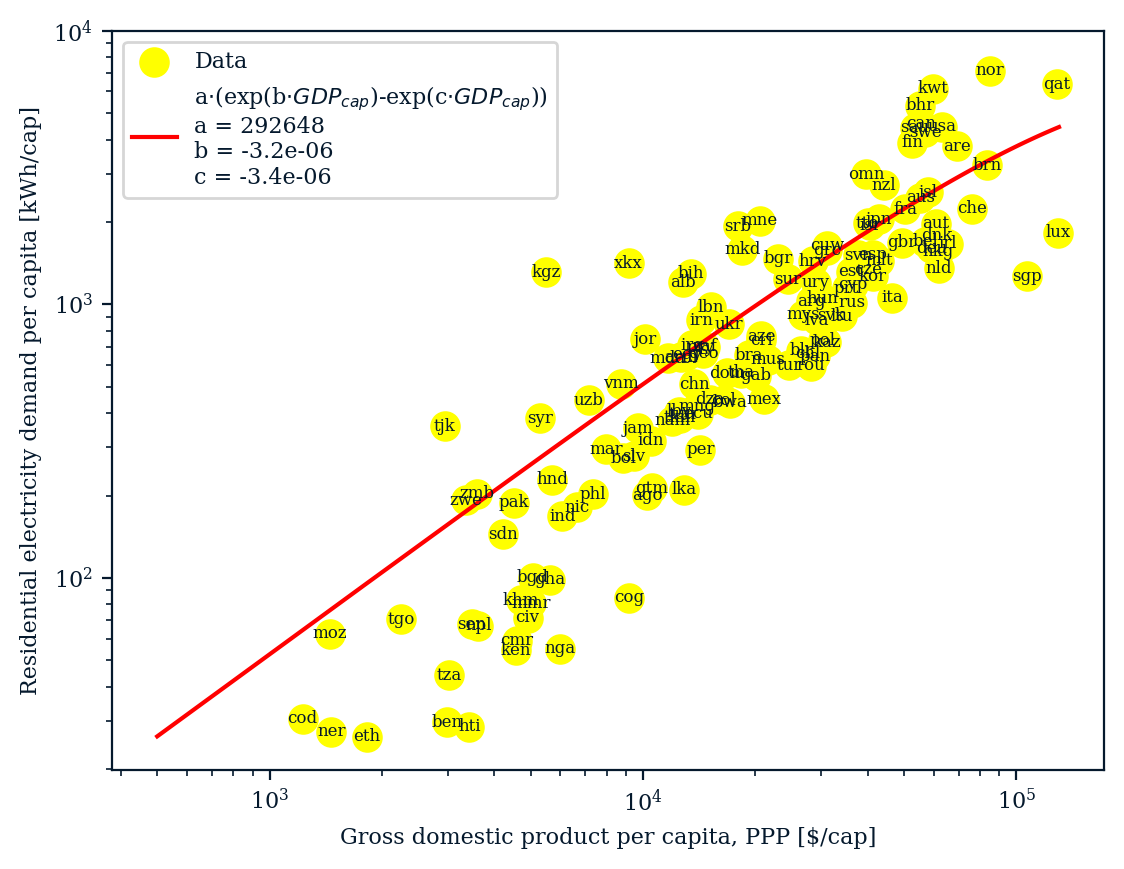

,Country,Code,GDP_perCapita,Elec_allSec_perCapita,Elec_allSec_TWh,Elec_Res_TWh,Res_share,Elec_Res_perCapita
0,Angola,ago,10250.592404,309.711408,8.4,5.428889,0.646296,200.165336
1,Albania,alb,12788.747231,2309.366503,6.7,3.499722,0.522347,1206.289742
2,United Arab Emirates,are,69409.037043,12677.059448,109.3,32.635000,0.298582,3785.140303
3,Argentina,arg,28200.815257,3049.362763,130.6,43.883889,0.336018,1024.639331
4,Armenia,arm,12667.375733,1895.613511,5.7,1.923889,0.337524,639.815749


In [10]:
## Method 1: Correlation between electricity demand and income level based on global statistics using two-term exponential regression

# importing global GDP and electricity consumption stats for the base year
# check the excel file for more details on data sources
gdp_elec_world = pd.read_excel('res_elec_gdp_corr_2015.xlsx', sheet_name='Data')
gdp_elec_world['Res_share'] = gdp_elec_world['Elec_Res_TWh'] / gdp_elec_world['Elec_allSec_TWh']
gdp_elec_world['Elec_Res_perCapita'] = gdp_elec_world['Elec_allSec_perCapita'] * gdp_elec_world['Res_share']

# defining a two-term exponential function
def two_term_exponential(x, a, b, c):
    return a * (np.exp(b * x) - np.exp(c * x))

# providing an initial guess for the parameters (coefficients)
initial_guess = [77210, -5*10**-6, -5*10**-6]

# fitting the two-term exponential model
x_data = gdp_elec_world['GDP_perCapita']
y_data = gdp_elec_world['Elec_Res_perCapita']
params, _ = curve_fit(two_term_exponential, x_data, y_data, p0=initial_guess, maxfev=100000)

# displaying the two-term exponential equation
a, b, c = params
print(f"Two-term exponential regression equation: Elec_Res_perCapita = {a:.0f} * (exp({b:.1e} * GDP_perCapita) - exp({c:.1e} * GDP_perCapita))")

# calculating the predicted values
y_pred = two_term_exponential(x_data, *params)

# calculating R-squared value, as an indicator for model fitness
r_squared = r2_score(y_data, y_pred)
print(f"R-squared: {r_squared:.2f}")

# plotting the data and the two-term exponential fit on a logarithmic scale
fig, ax = plt.subplots()
plt.scatter(x_data, y_data, label='Data', s=100, c='yellow') # original data points

# adding labels to data points
for i, txt in enumerate(gdp_elec_world['Code']):
    ax.annotate(txt, (x_data.iat[i], y_data.iat[i]), fontsize=6, alpha=1, ha='center', va='center')

# two-term exponential fit trendline
x_fit = np.linspace(500, 130000, 100)
y_fit = two_term_exponential(x_fit, *params)

# plotting trendline and legend
plt.plot(x_fit, y_fit, color='red',
         label="a$\cdot$(exp(b$\cdot$$GDP_{cap}$)-exp(c$\cdot$$GDP_{cap}$))\n"f"a = {a:.0f}\nb = {b:.1e}\nc = {c:.1e}")
plt.xscale('log') # x-axis scale
plt.yscale('log') # y-axis scale
plt.xlabel('Gross domestic product per capita, PPP [$/cap]') # x-axis label
plt.ylabel('Residential electricity demand per capita [kWh/cap]') # y-axis label
plt.ylim(top=10000) # upper limit of y-axis range
plt.legend()
plt.rcParams['font.family'] = 'serif' # font type
plt.rcParams['font.size'] = 8 # font size
plt.savefig('GDP_ResElec_corr.png', dpi=300) # saving the generated plot: file name and resolution
plt.show()

# displaying GDP and electricity consumption stats table for reference
gdp_elec_world.head()

### 6.1b Local fixed electricity demand intensity

In [96]:
## Method 2: Fixed electricity demand intensity for all income levels based on individual country stats

# retrieving official national electricity demand figures for the base year 2015
# total residential electricity consumption in TJ,
# from IEA: https://www.iea.org/data-and-statistics/data-tools/energy-statistics-data-browser
elec_cons_res = 3283
# share of population with access to electricity,
# from World Bank: https://data.worldbank.org/indicator/EG.ELC.ACCS.ZS?locations=NA
elec_access = 0.516

# retrieving official national socioeconomic indicators for the base year 2015
# total population in capita, 
# from World Bank: https://data.worldbank.org/indicator/SP.POP.TOTL?locations=NA
tot_pop_wb = 2374300
# GDP per capita PPP in constant 2021 international USD, 
# from World Bank: https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD?locations=NA
avg_inc_wb = 12167 

# US consumer price indices for currency base year conversion, 
# from: https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/
cpi_21 = 270.970 # 2021 US CPI
cpi_17 = 245.120 # 2017 US CPI
avg_inc_US17 = avg_inc_wb * cpi_17 / cpi_21 # GDP per capita PPP in constant 2017 international USD

# calculating access-corrected electricity consumption per capita and consumption intensity
avg_res_elec = (elec_cons_res * 10 ** 9 / 3600) / (tot_pop_wb * elec_access) # in kWh/capita
res_elec_intensity = avg_res_elec / avg_inc_US17 # in kWh/2017 intl USD

# displaying calculated parameters
print(f'Average electricity consumption: {avg_res_elec:.0f} kWh/cap/year')
print(f'Average electricity consumption intensity: {res_elec_intensity:.2f} kWh/constant international 2017 USD')


Average electricity consumption: 744 kWh/cap/year
Average electricity consumption intensity: 0.07 kWh/constant international 2017 USD


### 6.2 MTF classes

In [97]:
# Multi-Tier Framework classification
mtf_tiers_hh = [4.5, 73, 365, 1250, 3000] # in kWh/hh/year, annual household consumption, 5-person household (reference)
hh_size = 4.2 # in person/hh, Namibia 2013 (change as needed), from UN population division: https://popdiv.dfs.un.org/household/#/countries/

# calculating equivalent per capita consumption based on household size
mtf_tiers_cap = [tier / hh_size for tier in mtf_tiers_hh] # in kWh/cap/year, annual per capita consumption

# printing resulting MTF classes for the study region, change labels as needed
print(f'Multi-Tier Framework classification adjusted to Namibian household size:\nTier 1 >= {mtf_tiers_cap[0]:.1f} kWh/cap/year\nTier 2 >= {mtf_tiers_cap[1]:.0f} kWh/cap/year\nTier 3 >= {mtf_tiers_cap[2]:.0f} kWh/cap/year\nTier 4 >= {mtf_tiers_cap[3]:.0f} kWh/cap/year\nTier 5 >= {mtf_tiers_cap[4]:.0f} kWh/cap/year')

# Min. electricity demand to achieve universal electricity access per MTF definition
min_elec = mtf_tiers_cap[0]

# Max. cap is needed in case Method 2 is used for electricity demand estimation
# Max. electricity demand capped at 10x Tier 5, assumes demand saturation at very high income levels
# applied to currently electrified cells
max_elec = mtf_tiers_cap[-1] * 10 
# Max. electricity demand capped at current national average for currently unelectrified cells
max_unelec = avg_res_elec

# creating bins and labels for each Tier for later electricity consumption classification
mtf_bins = mtf_tiers_cap.copy()
mtf_bins.append(max_elec+1)
labels = [1, 2, 3, 4, 5]

Multi-Tier Framework classification adjusted to Namibian household size:
Tier 1 >= 1.1 kWh/cap/year
Tier 2 >= 17 kWh/cap/year
Tier 3 >= 87 kWh/cap/year
Tier 4 >= 298 kWh/cap/year
Tier 5 >= 714 kWh/cap/year


### 6.3 Electricity demand calculation per SSP, year, and populated cell

In [98]:
# calculating per capita and total electricity consumption for each cell & MTF class
for n in range(1,6): # looping over all SSPs (1-5)
    for x in range(2025,2055,5): # looping over all modelled years
        pop_inc_name = 'pop_inc_SSP' + str(n)
        res_elec_name = 'res_elec_SSP' + str(n) + '_' + str(x)
        
        # retrieving relevant columns
        locals()[res_elec_name] = locals()[pop_inc_name][['geometry', 'centroid', 'elec_stat', str(x) + '_POP',
                                                          str(x) + '_INC']].copy()
        
        # estimating per capita electricity demand based on income level using Method 1
        # either use this method or Method 2 on l.18, comment out the unused method
        locals()[res_elec_name][str(x) + '_perCapitaElec'] = two_term_exponential(locals()[pop_inc_name][str(x) + '_INC'],
                                                                                  *params)
        
        # estimating per capita electricity demand based on income level using Method 2
        # either use this method or Method 1 on l.13, comment out the unused method
        #locals()[res_elec_name][str(x) + '_perCapitaElec'] = locals()[pop_inc_name][str(x) + '_INC'] * res_elec_intensity
        
        # ensuring minimum demand corresponds to Tier 1 for all cells
        locals()[res_elec_name].loc[locals()[res_elec_name][str(x) + '_perCapitaElec'] < min_elec, str(x) + '_perCapitaElec']\
        = min_elec
        
        # ensuring maximum demand corresponds to 10x Tier 5 for currently electrified cells (uncomment if using Method 2)
        #locals()[res_elec_name].loc[(locals()[res_elec_name][str(x) + '_perCapitaElec'] > max_elec) & (locals()[res_elec_name]           ['elec_stat'] == True), str(x) + '_perCapitaElec'] = max_elec
        
        # ensuring maximum demand corresponds to historical national average for currently unelectrified cells 
        # (uncomment if using Method 2)
        #locals()[res_elec_name].loc[(locals()[res_elec_name][str(x) + '_perCapitaElec'] > max_unelec) & (locals()[res_elec_name]         ['elec_stat'] == False), str(x) + '_perCapitaElec'] = max_unelec
        
        # calculating total demand per cell based on population count
        locals()[res_elec_name][str(x) + '_TotElec']\
        = locals()[res_elec_name][str(x) + '_perCapitaElec'] * locals()[pop_inc_name][str(x) + '_POP']
        
        # classifying each cell according to MTF based on per capita demand level
        locals()[res_elec_name][str(x) + '_MTF'] = pd.cut(locals()[res_elec_name][str(x) + '_perCapitaElec'], bins=mtf_bins,
                                                          labels=labels, right=False)

In [99]:
# displaying one of the resulting GeoDataFrames as an example
res_elec_SSP1_2025.head()

,geometry,centroid,elec_stat,2025_POP,2025_INC,2025_perCapitaElec,2025_TotElec,2025_MTF
496,"POLYGON ((14.21708 -17.38375, 14.21708 -17.392...",POINT (14.22125 -17.38792),True,127.916825,138.048646,7.287492,932.192840,1
497,"POLYGON ((14.22542 -17.38375, 14.22542 -17.392...",POINT (14.22958 -17.38792),True,15.627386,1129.987126,59.453930,929.109485,2
543,"POLYGON ((14.21708 -17.39208, 14.21708 -17.400...",POINT (14.22125 -17.39625),True,87.350029,202.151673,10.669162,931.951576,1
607,"POLYGON ((14.77542 -17.39208, 14.77542 -17.400...",POINT (14.77958 -17.39625),True,41.822509,3194.978711,166.947393,6982.158809,3
608,"POLYGON ((14.78375 -17.39208, 14.78375 -17.400...",POINT (14.78792 -17.39625),True,86.611899,1542.767526,81.060410,7020.796020,2


### 6.4 Rasterising and saving disaggregated residential electricity demand and MTF tier maps for each SSP and year

In [100]:
# preparing GeoDataFrames for rasterisation, i.e. combining all years in one GeoDataFrame for each SSP
for n in range(1,6): # looping over all SSPs (1-5)
    res_elec_all_name = 'res_elec_SSP' + str(n) # joined GeoDataFrame name
    for x in range(2025,2050,5): # looping over all modelled years
        res_elec_left_name = 'res_elec_SSP' + str(n) + '_' + str(x) # left GeoDataFrame name
        res_elec_right_name = 'res_elec_SSP' + str(n) + '_' + str(x+5) # right GeoDataFrame name       
        
        locals()[res_elec_right_name].set_geometry('centroid', inplace=True)
        
        # joining GeoDataFrames
        if x == 2025:
            locals()[res_elec_all_name] = locals()[res_elec_left_name].sjoin(locals()[res_elec_right_name], how='left',
                                                                         predicate='contains')
        else:
            locals()[res_elec_all_name] = locals()[res_elec_all_name].sjoin(locals()[res_elec_right_name], how='left',
                                                                         predicate='contains')
        # dropping repeated columns
        locals()[res_elec_all_name].drop(columns=['index_right', 'geometry_right'], inplace=True)
        if x % 2 == 0:
            locals()[res_elec_all_name].drop(columns=['elec_stat_right'], inplace=True)
        else:
            locals()[res_elec_all_name].drop(columns=['elec_stat_left'], inplace=True)
    
    # dropping repeated columns
    locals()[res_elec_all_name] = locals()[res_elec_all_name][[col for col in locals()[res_elec_all_name].columns if col != 'elec_stat_right'] + ['elec_stat_right']]
    locals()[res_elec_all_name].rename(columns={'elec_stat_right': 'elec_stat'}, inplace=True)

# Rasterising avg. electricity demand, total electricity demand & MTF tiers
for n in range(1,6): # looping over all SSPs (1-5)
    name_res_elec = 'res_elec_SSP' + str(n)
    gdf = locals()[name_res_elec]
    pixel_size = 30/3600 # pixel size in degrees (e.g. 30 arc seconds, ~1 km), change as needed
    ind_1 = 'perCapitaElec' # indicator name
    ind_2 = 'TotElec'
    ind_3 = 'MTF'
    years = np.arange(2025,2055,5) # modelled years, change as needed
    country = 'Namibia' # study region name, change as needed
    out_1 = 'SSP' + str(n) + '_' + ind_1 + '_' + country + '.tif' # output file name
    out_2 = 'SSP' + str(n) + '_' + ind_2 + '_' + country + '.tif'
    out_3 = 'SSP' + str(n) + '_' + ind_3 + '_' + country + '.tif'
    gdf2rast(gdf, pixel_size, ind_1, years, out_1) # rasterising per capita electricity consumption
    gdf2rast(gdf, pixel_size, ind_2, years, out_2) # rasterising total electricity consumption
    gdf2rast(gdf, pixel_size, ind_3, years, out_3) # rasterising MTF classes

In [101]:
# displaying one of the resulting joined GeoDataFrames as an example
res_elec_SSP1.head()

,geometry,centroid,2025_POP,2025_INC,2025_perCapitaElec,2025_TotElec,2025_MTF,2030_POP,2030_INC,2030_perCapitaElec,2030_TotElec,2030_MTF,2035_POP,2035_INC,2035_perCapitaElec,2035_TotElec,2035_MTF,2040_POP,2040_INC,2040_perCapitaElec,2040_TotElec,2040_MTF,2045_POP,2045_INC,2045_perCapitaElec,2045_TotElec,2045_MTF,2050_POP,2050_INC,2050_perCapitaElec,2050_TotElec,2050_MTF,elec_stat
496,"POLYGON ((14.21708 -17.38375, 14.21708 -17.392...",POINT (14.22125 -17.38792),127.916825,138.048646,7.287492,932.192840,1,137.392873,153.188832,8.086323,1111.003146,1,145.697728,173.002991,9.131641,1330.459403,1,153.072818,199.727657,10.541312,1613.588371,1,159.848484,233.616708,12.328528,1970.696446,1,166.112438,273.842436,14.449397,2400.224497,1,True
497,"POLYGON ((14.22542 -17.38375, 14.22542 -17.392...",POINT (14.22958 -17.38792),15.627386,1129.987126,59.453930,929.109485,2,16.785059,1253.916013,65.947108,1106.926067,2,17.799649,1416.103365,74.436680,1324.946775,2,18.700651,1634.856169,85.872534,1605.872318,2,19.528423,1912.252528,100.350049,1959.678227,3,20.293680,2241.517287,117.499717,2384.501661,3,True
543,"POLYGON ((14.21708 -17.39208, 14.21708 -17.400...",POINT (14.22125 -17.39625),87.350029,202.151673,10.669162,931.951576,1,93.820899,224.322219,11.838402,1110.689522,1,99.492000,253.337102,13.368341,1330.042955,1,104.528197,292.471393,15.431400,1613.016442,1,109.155068,342.096860,18.046752,1969.894400,2,113.432508,401.001444,21.150004,2399.097959,2,True
607,"POLYGON ((14.77542 -17.39208, 14.77542 -17.400...",POINT (14.77958 -17.39625),41.822509,3194.978711,166.947393,6982.158809,3,44.920710,3545.381072,185.040297,8312.141556,3,47.635989,4003.957212,208.654440,9939.460662,3,50.047281,4622.469171,240.389248,12030.828205,3,52.262590,5406.792677,280.441980,14656.624285,3,54.310595,6337.771332,327.709806,17798.114577,4,True
608,"POLYGON ((14.78375 -17.39208, 14.78375 -17.400...",POINT (14.78792 -17.39625),86.611899,1542.767526,81.060410,7020.796020,2,93.028088,1711.967209,89.899715,8363.198566,3,98.651267,1933.401040,101.452702,10008.437588,3,103.644907,2232.063489,117.007846,12127.267327,3,108.232679,2610.791782,136.688290,14794.139819,3,112.473974,3060.335822,159.983822,17994.016262,3,True


In [102]:
# Similarly for unelectrified populations ONLY
# preparing geodataframes for rasterisation
for n in range(1,6):
    res_elec_all_name = 'res_elec_SSP' + str(n)
    res_unelec_all_name = 'res_unelec_SSP' + str(n)
    # extracting currently unelectrified populated cells from the full GeoDataFrame, one GeoDataFrame per SSP
    locals()[res_unelec_all_name] = locals()[res_elec_all_name].loc[locals()[res_elec_all_name]['elec_stat'] == False]
    
    for x in range(2025,2055,5):
        res_elec_year_name = 'res_elec_SSP' + str(n) + '_' + str(x)
        res_unelec_year_name = 'res_unelec_SSP' + str(n) + '_' + str(x)    
        # extracting currently unelectrified populated cells from the full GeoDataFrame, one GeoDataFrame per SSP & year
        locals()[res_unelec_year_name] = locals()[res_elec_year_name].loc[locals()[res_elec_year_name]['elec_stat'] == False]

# rasterising avg. electricity demand, total electricity demand & MTF tiers
for n in range(1,6): # looping over all SSPs (1-5)
    name_res_unelec = 'res_unelec_SSP' + str(n)
    gdf = locals()[name_res_unelec]
    pixel_size = 30/3600 # pixel size in degrees (e.g. 30 arc seconds, ~1 km), change as needed
    ind_1 = 'perCapitaElec' # indicator name
    ind_2 = 'TotElec'
    ind_3 = 'MTF'
    years = np.arange(2025,2055,5) # modelled years, change as needed
    country = 'Namibia' # study region name, change as needed
    out_1 = 'SSP' + str(n) + '_' + ind_1 + '_' + country + '_unelectrified.tif' # output file name
    out_2 = 'SSP' + str(n) + '_' + ind_2 + '_' + country + '_unelectrified.tif'
    out_3 = 'SSP' + str(n) + '_' + ind_3 + '_' + country + '_unelectrified.tif'
    gdf2rast(gdf, pixel_size, ind_1, years, out_1) # rasterising per capita electricity consumption
    gdf2rast(gdf, pixel_size, ind_2, years, out_2) # rasterising total electricity consumption
    gdf2rast(gdf, pixel_size, ind_3, years, out_3) # rasterising MTF classes

In [104]:
# displaying one of the resulting joined GeoDataFrames (for unelectrified only) as an example
res_unelec_SSP1.sort_values('2050_perCapitaElec').tail()

,geometry,centroid,2025_POP,2025_INC,2025_perCapitaElec,2025_TotElec,2025_MTF,2030_POP,2030_INC,2030_perCapitaElec,2030_TotElec,2030_MTF,2035_POP,2035_INC,2035_perCapitaElec,2035_TotElec,2035_MTF,2040_POP,2040_INC,2040_perCapitaElec,2040_TotElec,2040_MTF,2045_POP,2045_INC,2045_perCapitaElec,2045_TotElec,2045_MTF,2050_POP,2050_INC,2050_perCapitaElec,2050_TotElec,2050_MTF,elec_stat
70091,"POLYGON ((15.47542 -20.75042, 15.47542 -20.758...",POINT (15.47958 -20.75458),3.612679,150435.471171,4807.215181,17366.927163,5,3.880306,166934.155214,5048.463395,19589.581874,5,4.114855,188526.198202,5304.807270,21828.512370,5,4.323145,217648.814190,5556.700269,24022.422374,5,4.514506,254578.661558,5745.447380,25937.858787,5,4.691416,298413.761996,5817.674067,27293.126496,5,False
70036,"POLYGON ((15.45875 -20.74208, 15.45875 -20.750...",POINT (15.46292 -20.74625),17.789788,150435.471171,4807.215181,85519.340739,5,19.107652,166934.155214,5048.463395,96464.280150,5,20.262634,188526.198202,5304.807270,107489.365830,5,21.288310,217648.814190,5556.700269,118292.758709,5,22.230623,254578.661558,5745.447380,127724.873999,5,23.101770,298413.761996,5817.674067,134398.570498,5,False
70094,"POLYGON ((15.50875 -20.75042, 15.50875 -20.758...",POINT (15.51292 -20.75458),8.424959,150435.471171,4807.215181,40500.589601,5,9.049078,166934.155214,5048.463395,45683.937548,5,9.596059,188526.198202,5304.807270,50905.241485,5,10.081803,217648.814190,5556.700269,56021.555263,5,10.528067,254578.661558,5745.447380,60488.453945,5,10.940628,298413.761996,5817.674067,63649.009682,5,False
70719,"POLYGON ((15.46708 -20.83375, 15.46708 -20.842...",POINT (15.47125 -20.83792),10.758922,150435.471171,4807.215181,51720.451829,5,11.555940,166934.155214,5048.463395,58339.740597,5,12.254451,188526.198202,5304.807270,65007.500286,5,12.874760,217648.814190,5556.700269,71541.184435,5,13.444653,254578.661558,5745.447380,77245.546282,5,13.971506,298413.761996,5817.674067,81281.669519,5,False
70368,"POLYGON ((15.48375 -20.79208, 15.48375 -20.800...",POINT (15.48792 -20.79625),10.916185,150435.471171,4807.215181,52476.449349,5,11.724853,166934.155214,5048.463395,59192.492219,5,12.433574,188526.198202,5304.807270,65957.714509,5,13.062951,217648.814190,5556.700269,72586.901478,5,13.641173,254578.661558,5745.447380,78374.643947,5,14.175728,298413.761996,5817.674067,82469.763171,5,False
70718,"POLYGON ((15.45875 -20.83375, 15.45875 -20.842...",POINT (15.46292 -20.83792),3.812656,150435.471171,4807.215181,18328.256511,5,4.095096,166934.155214,5048.463395,20673.944110,5,4.342629,188526.198202,5304.807270,23036.808424,5,4.562449,217648.814190,5556.700269,25352.160181,5,4.764402,254578.661558,5745.447380,27373.623712,5,4.951104,298413.761996,5817.674067,28803.910946,5,False
70637,"POLYGON ((15.47542 -20.82542, 15.47542 -20.833...",POINT (15.47958 -20.82958),2.758573,150435.471171,4807.215181,13261.054992,5,2.962928,166934.155214,5048.463395,14958.231820,5,3.142025,188526.198202,5304.807270,16667.836527,5,3.301071,217648.814190,5556.700269,18343.064444,5,3.447191,254578.661558,5745.447380,19805.655228,5,3.582276,298413.761996,5817.674067,20840.511852,5,False
70636,"POLYGON ((15.46708 -20.82542, 15.46708 -20.833...",POINT (15.47125 -20.82958),4.222801,150435.471171,4807.215181,20299.915246,5,4.535626,166934.155214,5048.463395,22897.939745,5,4.809786,188526.198202,5304.807270,25514.988742,5,5.053253,217648.814190,5556.700269,28079.414028,5,5.276932,254578.661558,5745.447380,30318.336117,5,5.483718,298413.761996,5817.674067,31902.486230,5,False
70558,"POLYGON ((15.46708 -20.81708, 15.46708 -20.825...",POINT (15.47125 -20.82125),2.038594,150435.471171,4807.215181,9799.958597,5,2.189612,166934.155214,5048.463395,11054.177259,5,2.321966,188526.198202,5304.807270,12317.580160,5,2.439501,217648.814190,5556.700269,13555.578512,5,2.547484,254578.661558,5745.447380,14636.437398,5,2.647312,298413.761996,5817.674067,15401.199483,5,False
70315,"POLYGON ((15.49208 -20.78375, 15.49208 -20.792...",POINT (15.49625 

## 7. Summary statistics: tables and figures

This part calculates summary statistics that are useful for comparing the development of socio-economic indicators and electricity demand across different SSP narratives. Several plotting options are available for different statistics. Tables and figures can always be adjusted and/or supplemented based on user needs.

### 7.1 Summary table of average residential electricity demand per SSP and year

In [105]:
# constructing average residential electricity demand DataFrame
country = 'Namibia' # study region name, change as needed
n_scenario = 5 # number of SSPs
start_year = 2025
end_year = 2050
year_int = 5 # time interval between modelled years

# initialising the DataFrame
res_elec_proj = pd.DataFrame({'Year': np.arange(start_year, end_year + year_int, year_int)})

for n in range(1, n_scenario + 1):
    name_res_elec = 'res_elec_SSP' + str(n)

    # creating initial zero columns for each SSP
    col_name = 'SSP' + str(n)
    res_elec_proj[col_name] = 0
    
    for x in range(start_year, end_year + year_int, year_int):
        # populating each SSP column with country-specific average residential electricity demand
        res_elec_proj.loc[res_elec_proj['Year'] == x, [col_name]] = (locals()[name_res_elec][str(x)+'_TotElec'].sum() \
                                                                    / pop_proj.loc[pop_proj['Year'] == x, [col_name]]).round(3)

# displaying the resulting DataFrame
res_elec_proj

,Year,SSP1,SSP2,SSP3,SSP4,SSP5
0,2025,362.840,361.710,361.113,361.397,363.775
1,2030,393.915,376.172,369.423,375.491,398.324
2,2035,433.154,394.752,379.077,392.720,442.104
3,2040,483.810,414.878,387.521,411.177,498.512
4,2045,544.796,440.741,397.552,433.485,566.232
5,2050,613.155,471.138,407.683,457.636,642.251


In [106]:
# Similarly for unelectrified populations ONLY
res_unelec_proj = pd.DataFrame({'Year': np.arange(start_year, end_year + year_int, year_int)})

for n in range(1, n_scenario + 1):
    name_res_unelec = 'res_unelec_SSP' + str(n)

    # creating zero columns for each SSP
    col_name = 'SSP' + str(n)
    res_unelec_proj[col_name] = 0
    
    for x in range(start_year, end_year + year_int, year_int):
        # populating each SSP column with country-specific average residential electricity demand
        res_unelec_proj.loc[res_elec_proj['Year'] == x, [col_name]] = (locals()[name_res_unelec][str(x)+'_TotElec'].sum() \
                                                                    / pop_proj.loc[pop_proj['Year'] == x, [col_name]]).round(3)

# displaying the resulting DataFrame
res_unelec_proj

,Year,SSP1,SSP2,SSP3,SSP4,SSP5
0,2025,240.089,239.404,239.041,239.214,240.656
1,2030,258.806,248.148,244.074,247.738,261.442
2,2035,282.103,259.307,249.899,258.091,287.365
3,2040,311.640,271.299,254.974,269.101,320.102
4,2045,346.425,286.565,260.981,282.298,358.455
5,2050,384.445,304.307,267.023,296.453,400.326


### 7.2 Plotting socio-economic indicators and electricity demand development under different SSPs

In [107]:
# changing population and income level order of magnitude to enhance readability
pop_proj_mil = pop_proj.copy()
pop_proj_mil.iloc[:,1:6] = pop_proj_mil.iloc[:,1:6] / 10 ** 6 # population in millions
inc_proj_k = inc_proj.copy()
inc_proj_k.iloc[:,1:6] = inc_proj_k.iloc[:,1:6] / 1000 # income level in thousands

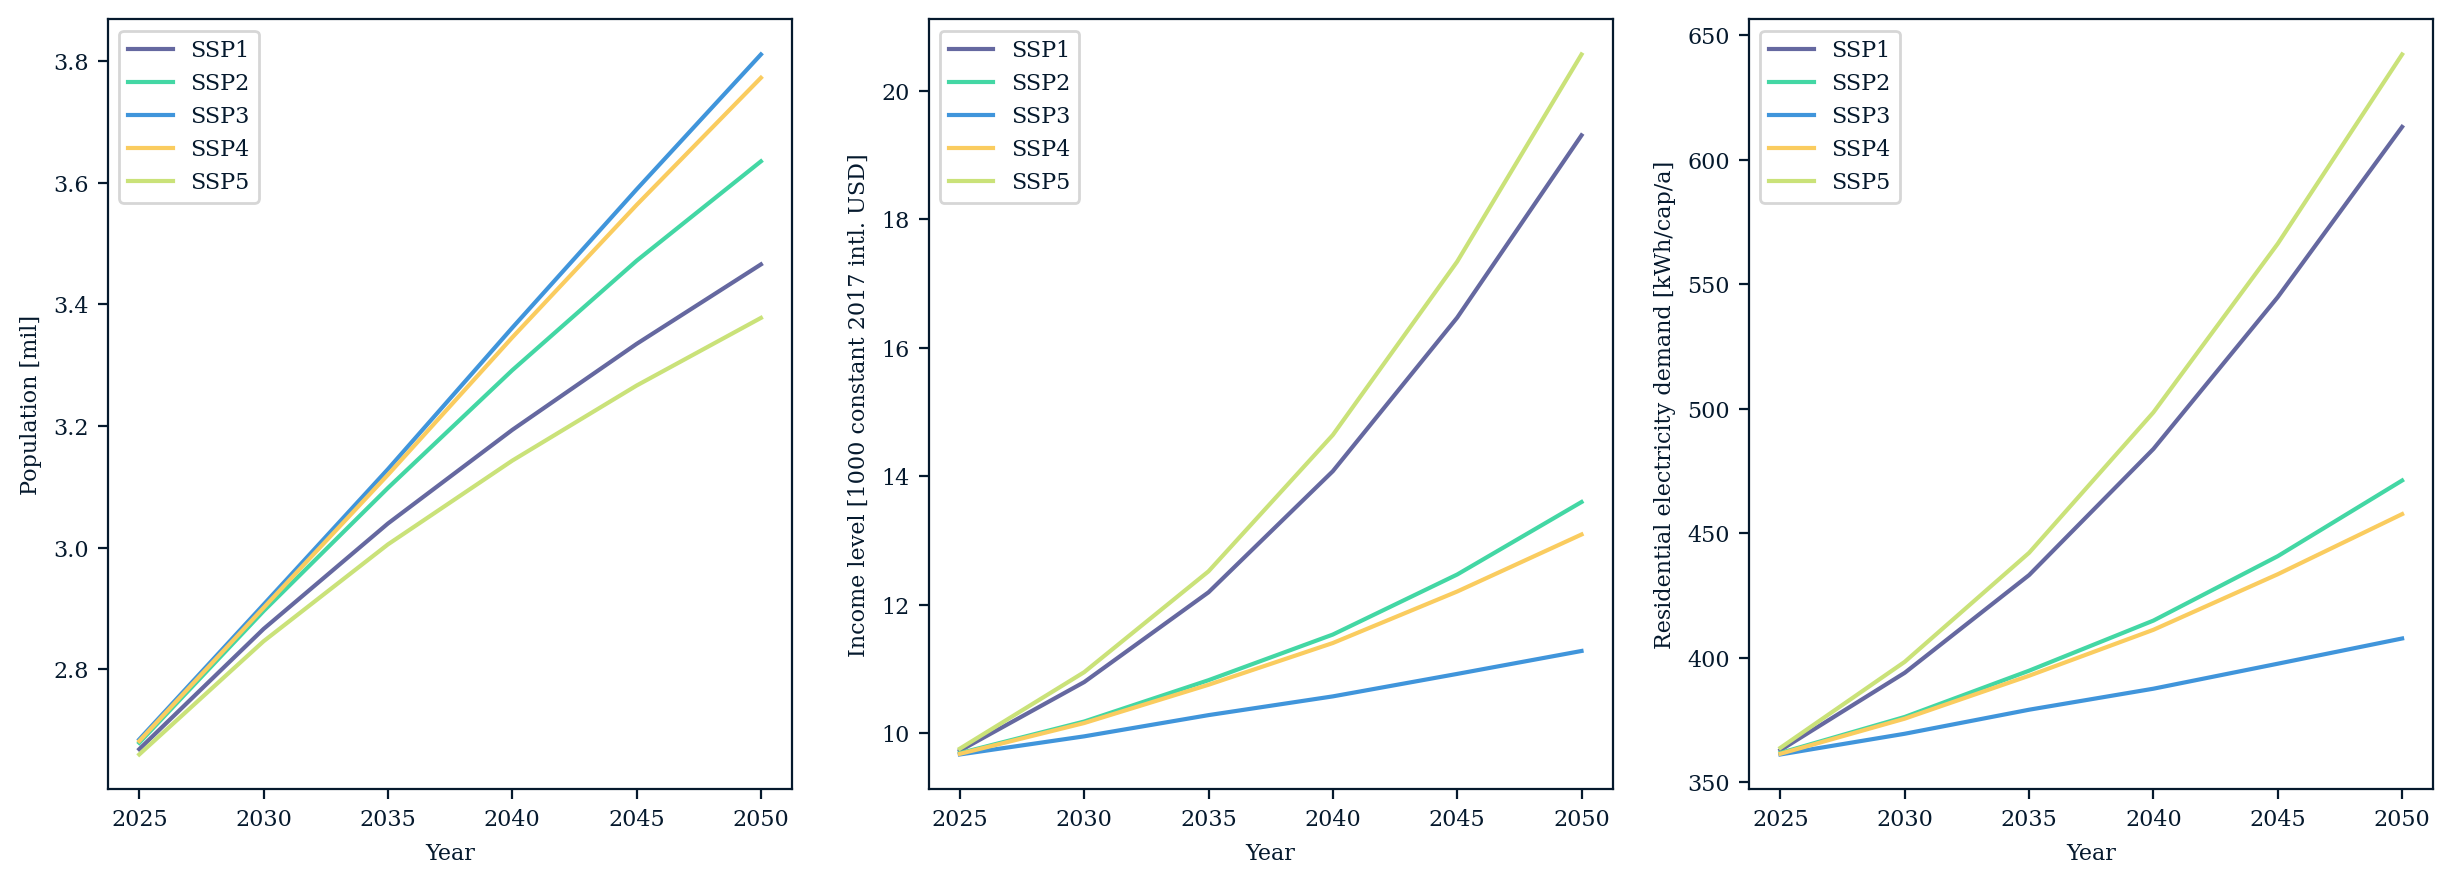

In [108]:
# plotting summary stats for population, income level & electricity demand development by SSP
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, figsize=(15,5)) # creating 3 sub-plots for the 3 indicators
# 1st sub-plot: total population development
pop_proj_mil.plot(x='Year', kind='line', ax=ax1, ylabel='Population [mil]')
# 2nd sub-plot: average income level development
inc_proj_k.plot(x='Year', kind='line', ax=ax2, ylabel='Income level [1000 constant 2017 intl. USD]')
# 3rd sub-plot: average residential electricity demand development
res_elec_proj.plot(x='Year', kind='line', ax=ax3, ylabel='Residential electricity demand [kWh/cap/a]')
plt.rcParams['font.family'] = 'serif' # font type
plt.rcParams['font.size'] = 8 # font size
plt.savefig('summary_stats_pop_inc_elec.png', dpi=300) # saving output figure: file name and resolution
plt.show()

### 7.3 Plotting population and electricity demand breakdown by MTF class

        Tier 1    Tier 2    Tier 3    Tier 4    Tier 5
SSP1  0.156828  0.306079  1.135853  1.225367  0.641533
SSP2  0.207536  0.442739  1.666507  0.832234  0.486046
SSP3  0.241030  0.597075  1.873699  0.653051  0.445950
SSP4  0.221169  0.471986  1.821168  0.768908  0.489191
SSP5  0.137144  0.294474  1.020107  1.256269  0.669718
        Tier 1     Tier 2      Tier 3      Tier 4       Tier 5
SSP1  1.223822  14.979540  221.443418  542.778007  1344.560314
SSP2  1.545748  22.778711  311.538620  358.285175  1018.467901
SSP3  1.723194  32.037716  334.732747  279.129050   905.978606
SSP4  1.646709  24.228447  341.988726  337.019312  1021.514097
SSP5  0.988194  14.071068  198.773453  561.904954  1393.601100


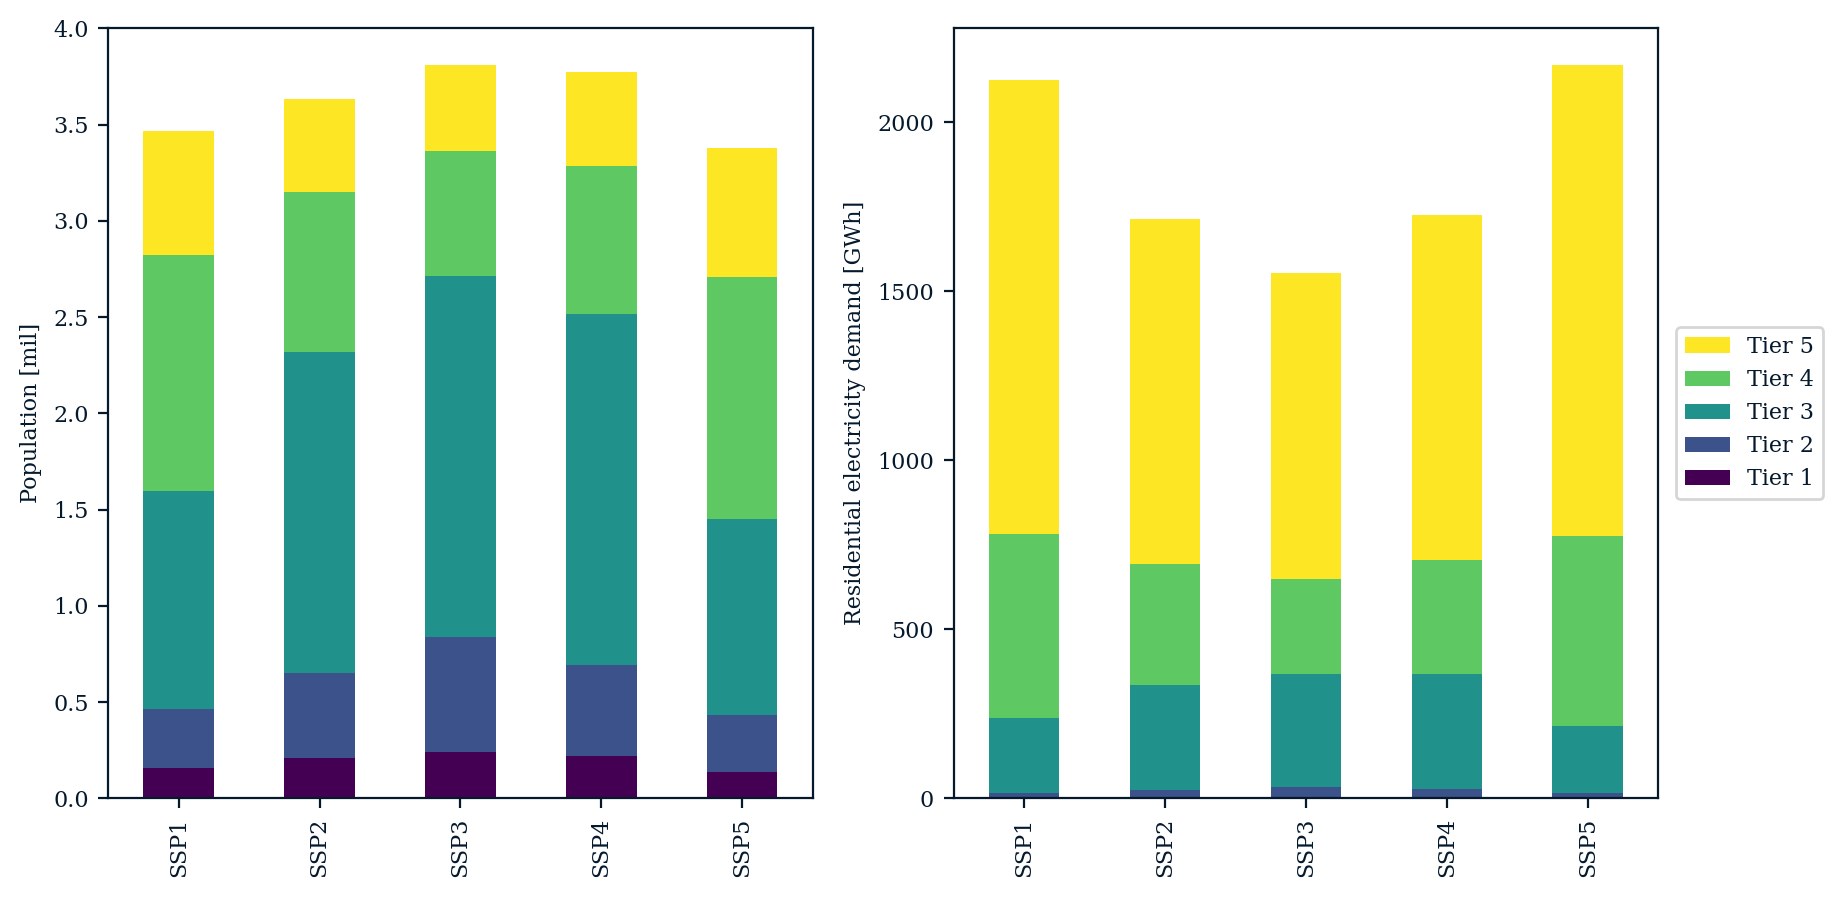

In [109]:
# plotting summary stats for population & total electricity demand by MTF tiers
# setting up required DataFrames for plotting
pop_by_MTF = pd.DataFrame({'MTF': np.arange(1, 6)}) # empty population DataFrame, columns correspond to MTF tiers
elec_by_MTF = pd.DataFrame({'MTF': np.arange(1, 6)}) # empty electricity demand DataFrame, columns correspond to MTF tiers
year = str(2050) # plotted year, change as needed
for n in range(1,6): # looping over all SSPs (1-5)
    res_elec_name = 'res_elec_SSP' + str(n)
    # population in millions, summed up and grouped by MTF tiers
    pop_by_MTF['SSP'+str(n)] = locals()[res_elec_name].groupby(year+'_MTF')[year+'_POP'].sum().values / 10 ** 6
    # total residential electricity demand in GWh, summed up and grouped by MTF tiers
    elec_by_MTF['SSP'+str(n)] = locals()[res_elec_name].groupby(year+'_MTF')[year+'_TotElec'].sum().values / 10 ** 6

# transposing DataFrames for proper plotting
pop_by_MTF = pop_by_MTF.iloc[:,1:].transpose()
pop_by_MTF.columns = ['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5'] # renaming columns to full name instead of a single number
print(pop_by_MTF) # displaying resulting table

elec_by_MTF = elec_by_MTF.iloc[:,1:].transpose()
elec_by_MTF.columns = ['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5'] # renaming columns to full name instead of a single number
print(elec_by_MTF) # displaying resulting table

# creating 2 sub-plots for the 2 indicators
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(10,5)) 
# 1st sub-plot: total population in 2050 across different SSPs, broken down by MTF tier
pop_by_MTF.plot(kind='bar', stacked=True, cmap='viridis', ylabel='Population [mil]', ax=ax1)
ax1.get_legend().remove() # removing legend of 1st sub-plot, only one legend is used for both plots to avoid redundancy
# 2nd sub-plot: total residential electricity demand in 2050 across different SSPs, broken down by MTF tier
elec_by_MTF.plot(kind='bar', stacked=True, cmap='viridis', ylabel='Residential electricity demand [GWh]', ax=ax2)
ax2.legend(bbox_to_anchor = (1.25, 0.5), loc='center right', reverse=True) # setting legend properties
plt.rcParams['font.family'] = 'serif' # font type
plt.rcParams['font.size'] = 8 # font size
plt.savefig('summary_stats_byMTF.png', dpi=300) # saving output figure: file name and resolution
plt.show()

        Tier 1    Tier 2    Tier 3    Tier 4    Tier 5
SSP1  0.121504  0.213563  0.412593  0.192652  0.228176
SSP2  0.122198  0.215055  0.415432  0.192664  0.227741
SSP3  0.122527  0.215523  0.416502  0.193017  0.227965
SSP4  0.122374  0.215341  0.415990  0.192867  0.227798
SSP5  0.120898  0.212628  0.409992  0.193240  0.227948
        Tier 1     Tier 2     Tier 3     Tier 4      Tier 5
SSP1  0.864052  10.483403  73.326602  85.339380  470.729200
SSP2  0.867835  10.554902  73.874241  85.682184  470.450228
SSP3  0.869149  10.561898  73.957340  85.777423  470.627319
SSP4  0.868594  10.562402  73.926469  85.762470  470.500227
SSP5  0.860298  10.447217  72.848749  85.479360  470.540057


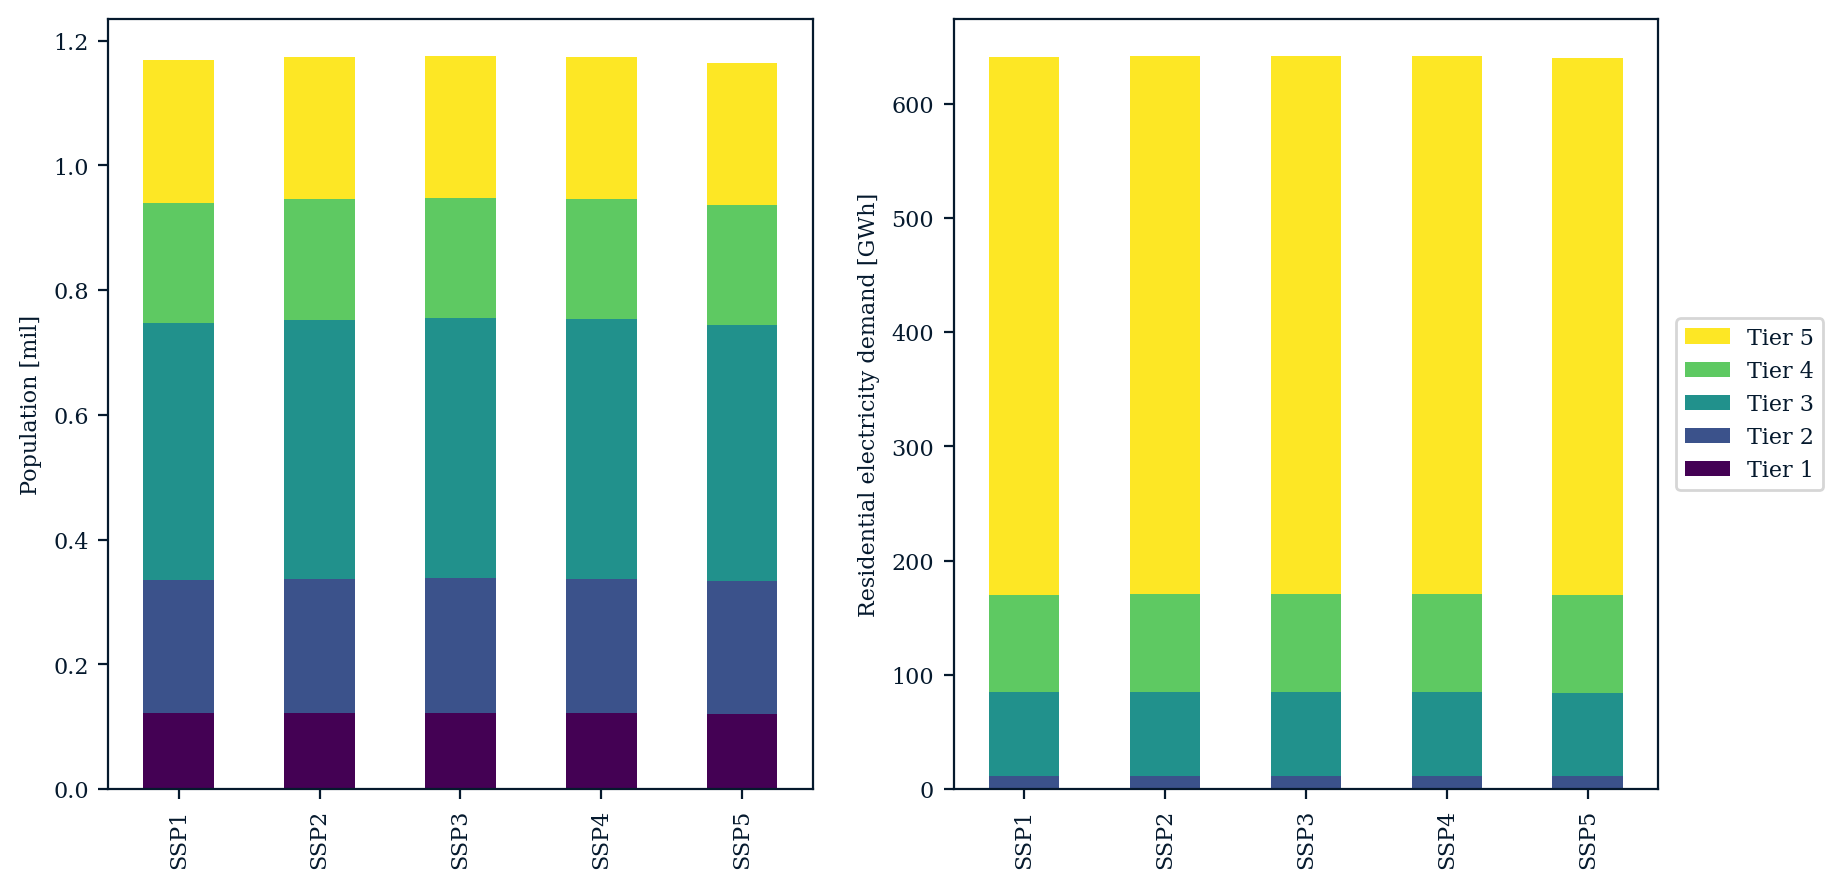

        Tier 1    Tier 2    Tier 3    Tier 4    Tier 5
SSP1  0.123330  0.214131  0.428447  0.228338  0.260805
SSP2  0.129098  0.226673  0.438676  0.218130  0.255332
SSP3  0.130668  0.229574  0.445684  0.214665  0.251975
SSP4  0.129367  0.227220  0.439938  0.218255  0.255503
SSP5  0.121674  0.208219  0.426258  0.228727  0.261302
        Tier 1     Tier 2     Tier 3      Tier 4      Tier 5
SSP1  0.897291  10.570924  77.674544  101.145258  551.572469
SSP2  0.931683  11.257117  78.783421   96.256575  531.369215
SSP3  0.933080  11.296860  79.559283   95.009328  522.596565
SSP4  0.931787  11.264995  78.915658   96.266446  531.374224
SSP5  0.889769  10.203559  77.364520  101.433885  554.228244


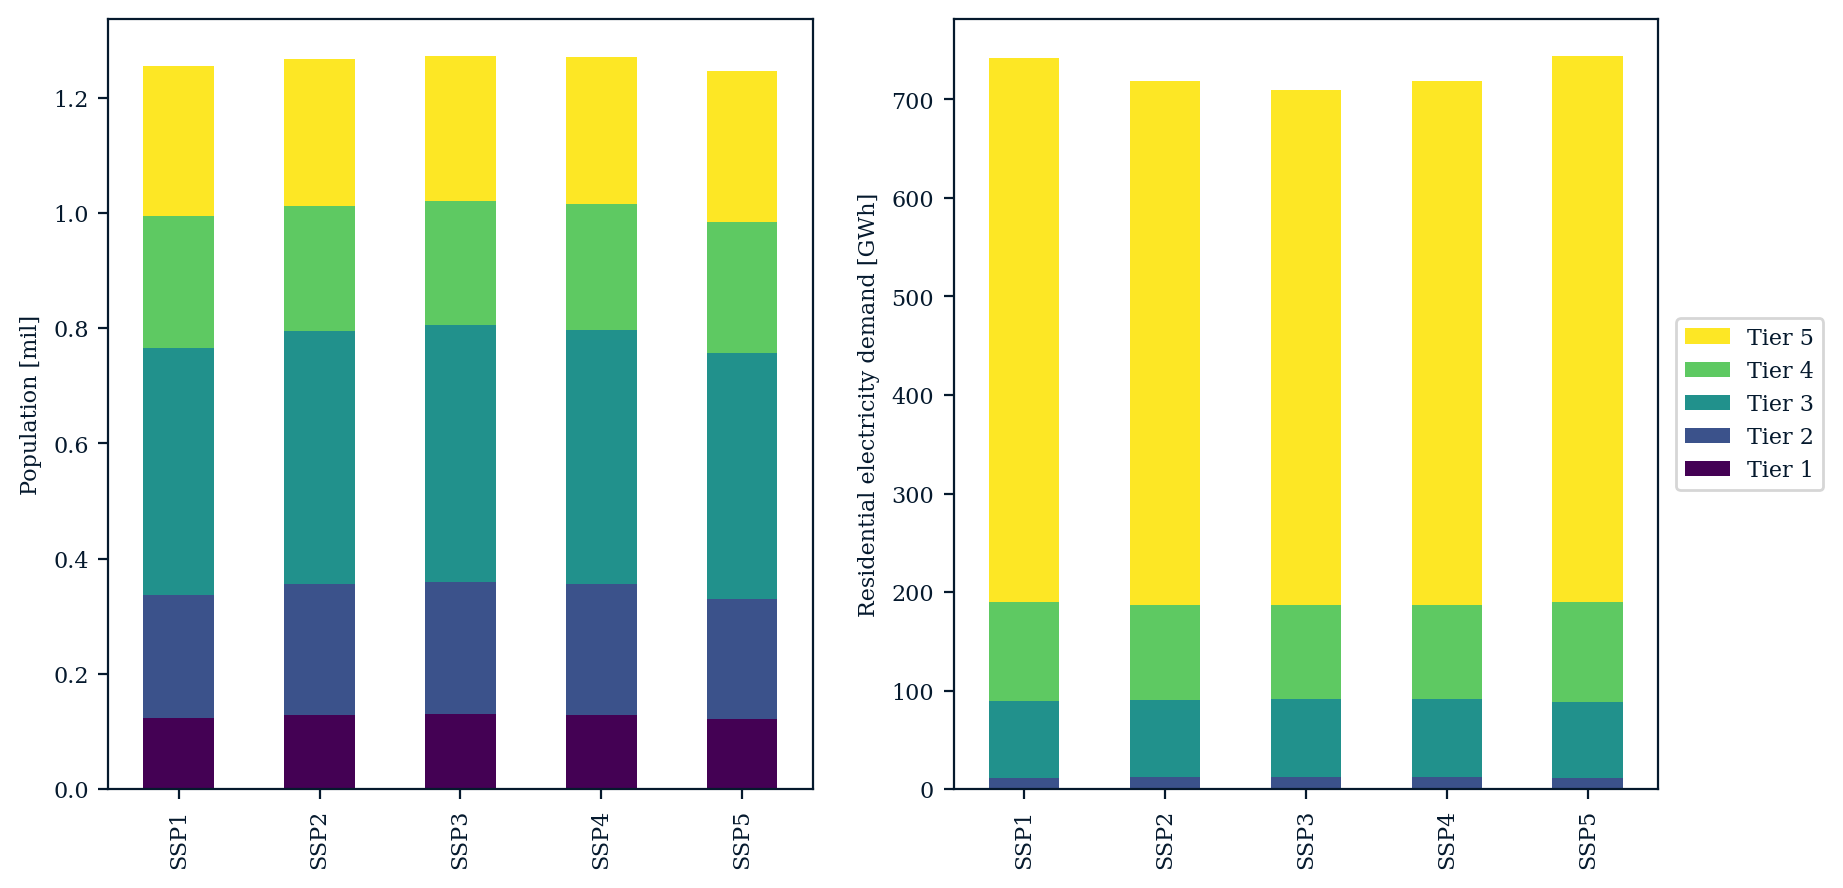

        Tier 1    Tier 2    Tier 3    Tier 4    Tier 5
SSP1  0.121303  0.208294  0.431013  0.272673  0.297630
SSP2  0.133271  0.230564  0.463213  0.247222  0.282238
SSP3  0.138598  0.243246  0.474124  0.236666  0.277396
SSP4  0.134744  0.233095  0.467979  0.246795  0.283348
SSP5  0.118559  0.202655  0.420514  0.275872  0.298276
        Tier 1     Tier 2     Tier 3      Tier 4      Tier 5
SSP1  0.898246  10.185849  79.156333  120.912212  646.367665
SSP2  0.971900  11.377469  84.025852  109.588080  597.421073
SSP3  1.000771  12.072974  85.437131  104.657477  578.784645
SSP4  0.981796  11.500934  84.829858  109.372774  598.504984
SSP5  0.887342   9.951328  77.635995  122.826677  652.345397


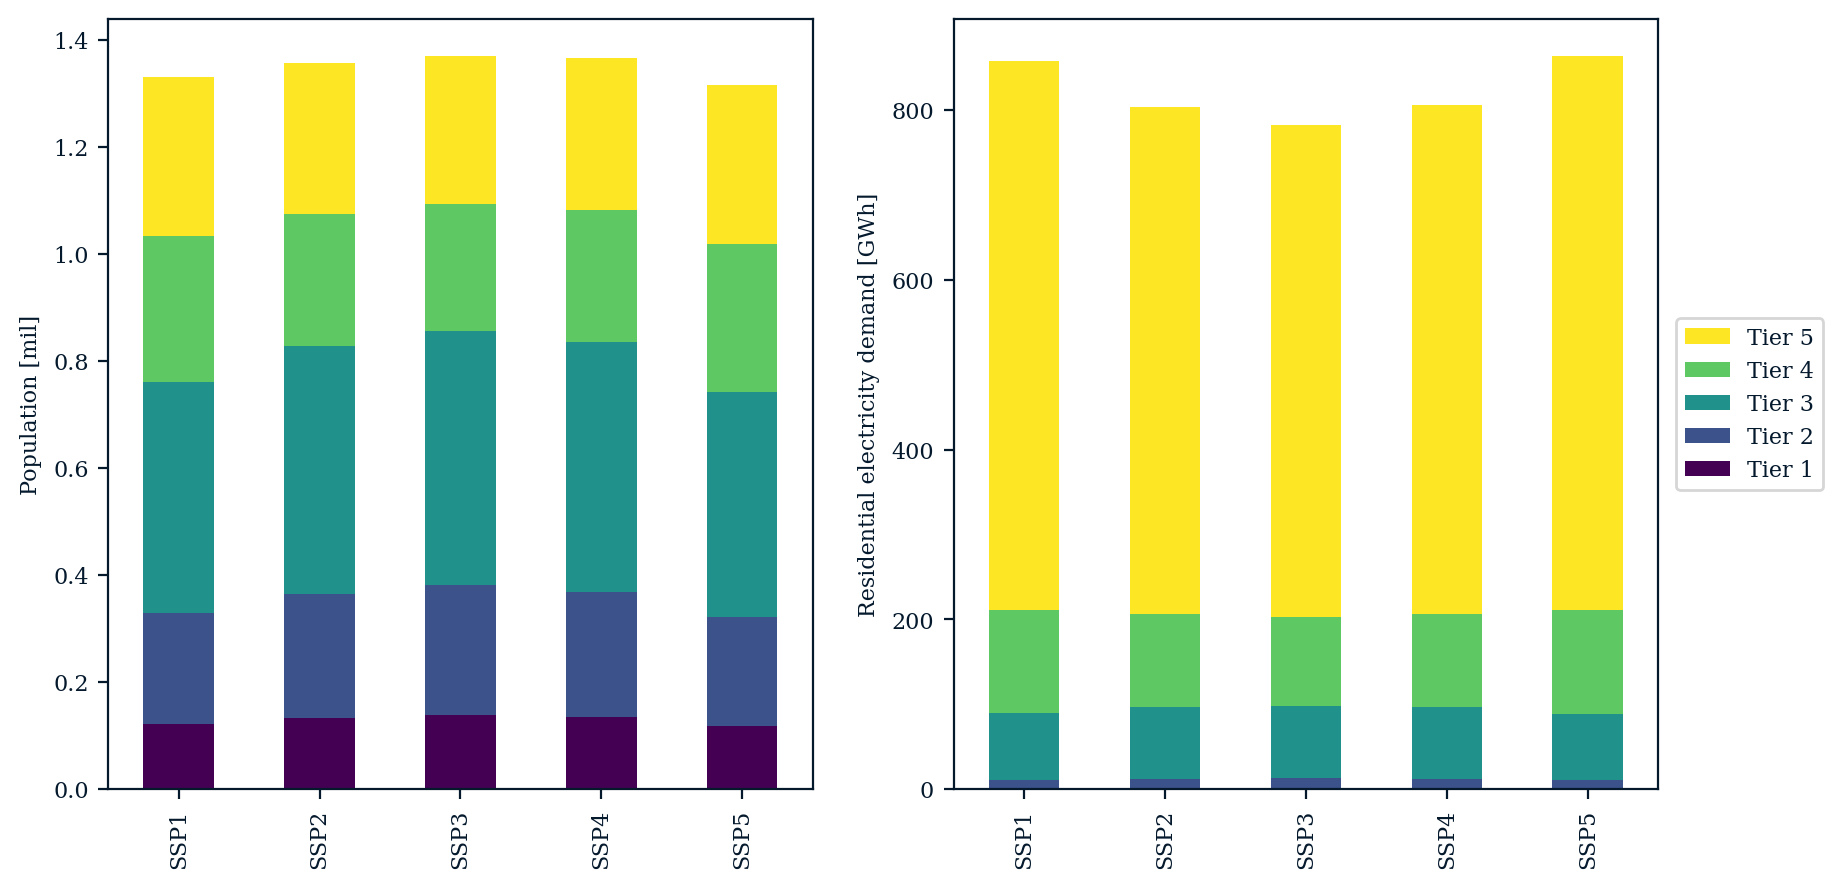

        Tier 1    Tier 2    Tier 3    Tier 4    Tier 5
SSP1  0.116435  0.197357  0.420635  0.326566  0.337290
SSP2  0.136648  0.232736  0.478791  0.279758  0.313294
SSP3  0.146806  0.256666  0.504069  0.262143  0.302106
SSP4  0.139604  0.237813  0.489790  0.281376  0.316235
SSP5  0.111679  0.190445  0.402633  0.331396  0.340012
        Tier 1     Tier 2     Tier 3      Tier 4      Tier 5
SSP1  0.879041   9.514868  78.227522  147.755350  758.880277
SSP2  1.010594  11.407427  87.226785  123.258930  670.127505
SSP3  1.068260  12.775313  91.326984  116.144528  635.779459
SSP4  1.028025  11.623069  89.007773  123.930169  674.707977
SSP5  0.846532   9.194678  75.142833  150.625003  770.302012


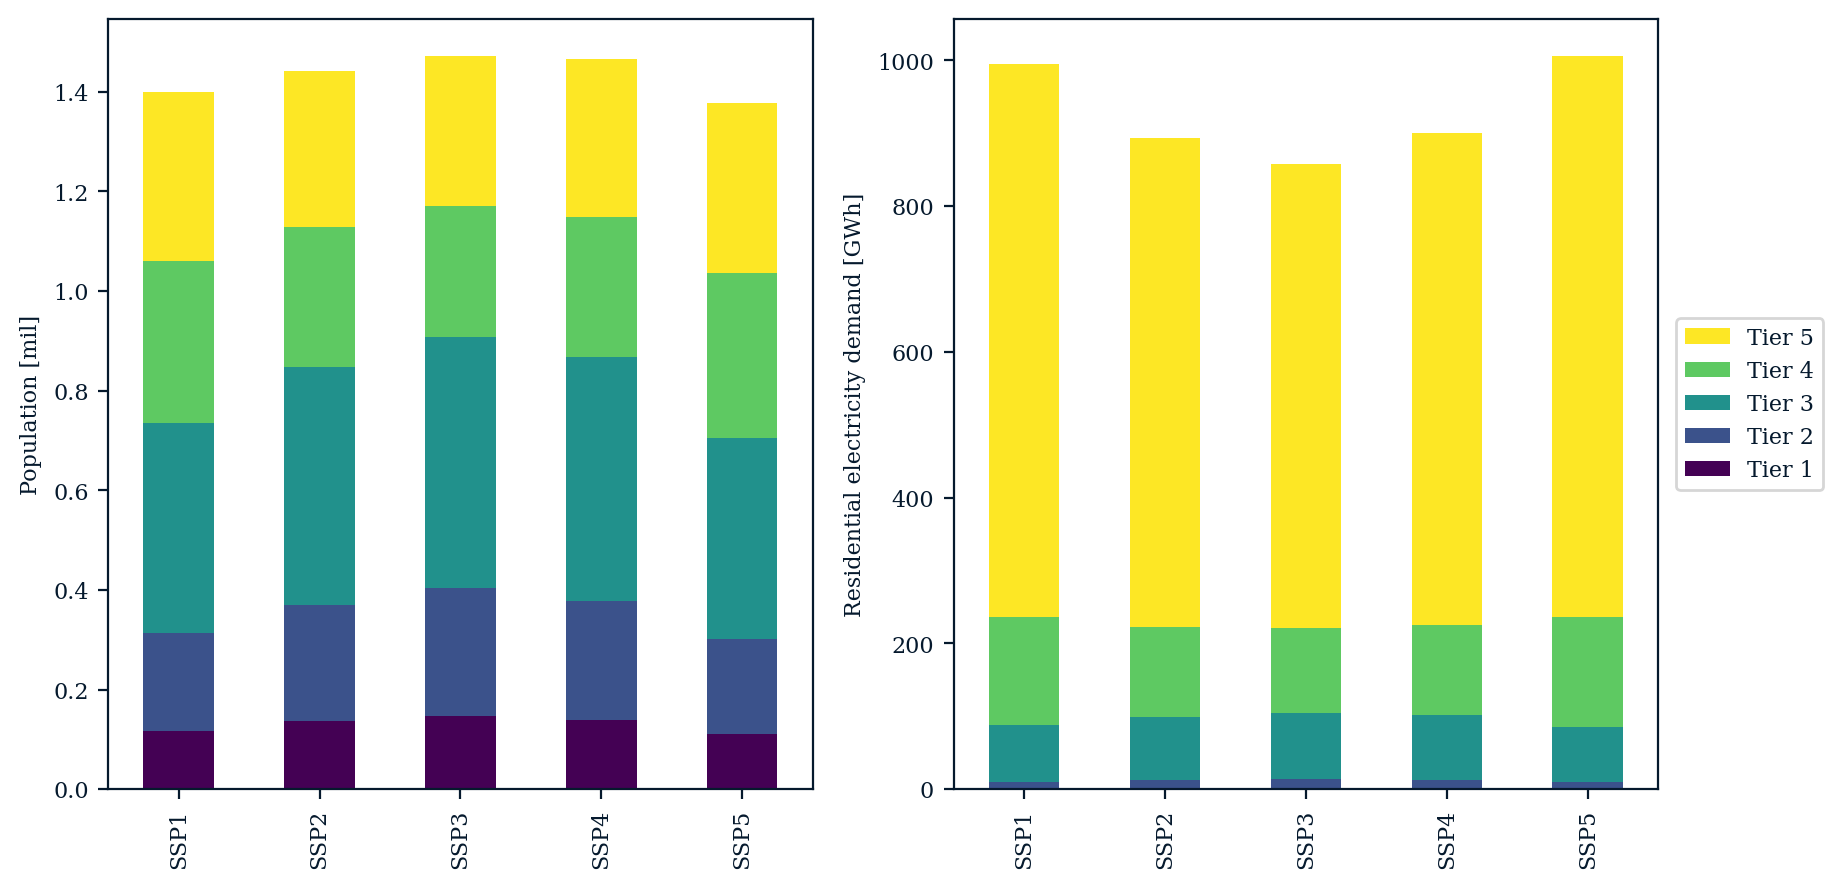

        Tier 1    Tier 2    Tier 3    Tier 4    Tier 5
SSP1  0.109155  0.190558  0.391713  0.375076  0.393675
SSP2  0.137027  0.235199  0.486671  0.317152  0.343969
SSP3  0.153733  0.262730  0.538063  0.288260  0.328604
SSP4  0.142184  0.244142  0.504874  0.320038  0.348936
SSP5  0.103549  0.180915  0.369590  0.378497  0.397651
        Tier 1     Tier 2     Tier 3      Tier 4      Tier 5
SSP1  0.833597   9.212338  73.636367  171.815666  899.818561
SSP2  1.022274  11.550830  89.849129  141.127786  751.304284
SSP3  1.124570  12.871511  97.585687  127.923307  697.151088
SSP4  1.053750  11.948177  92.757204  141.976629  758.193206
SSP5  0.798927   8.739543  69.620124  175.004778  916.735010


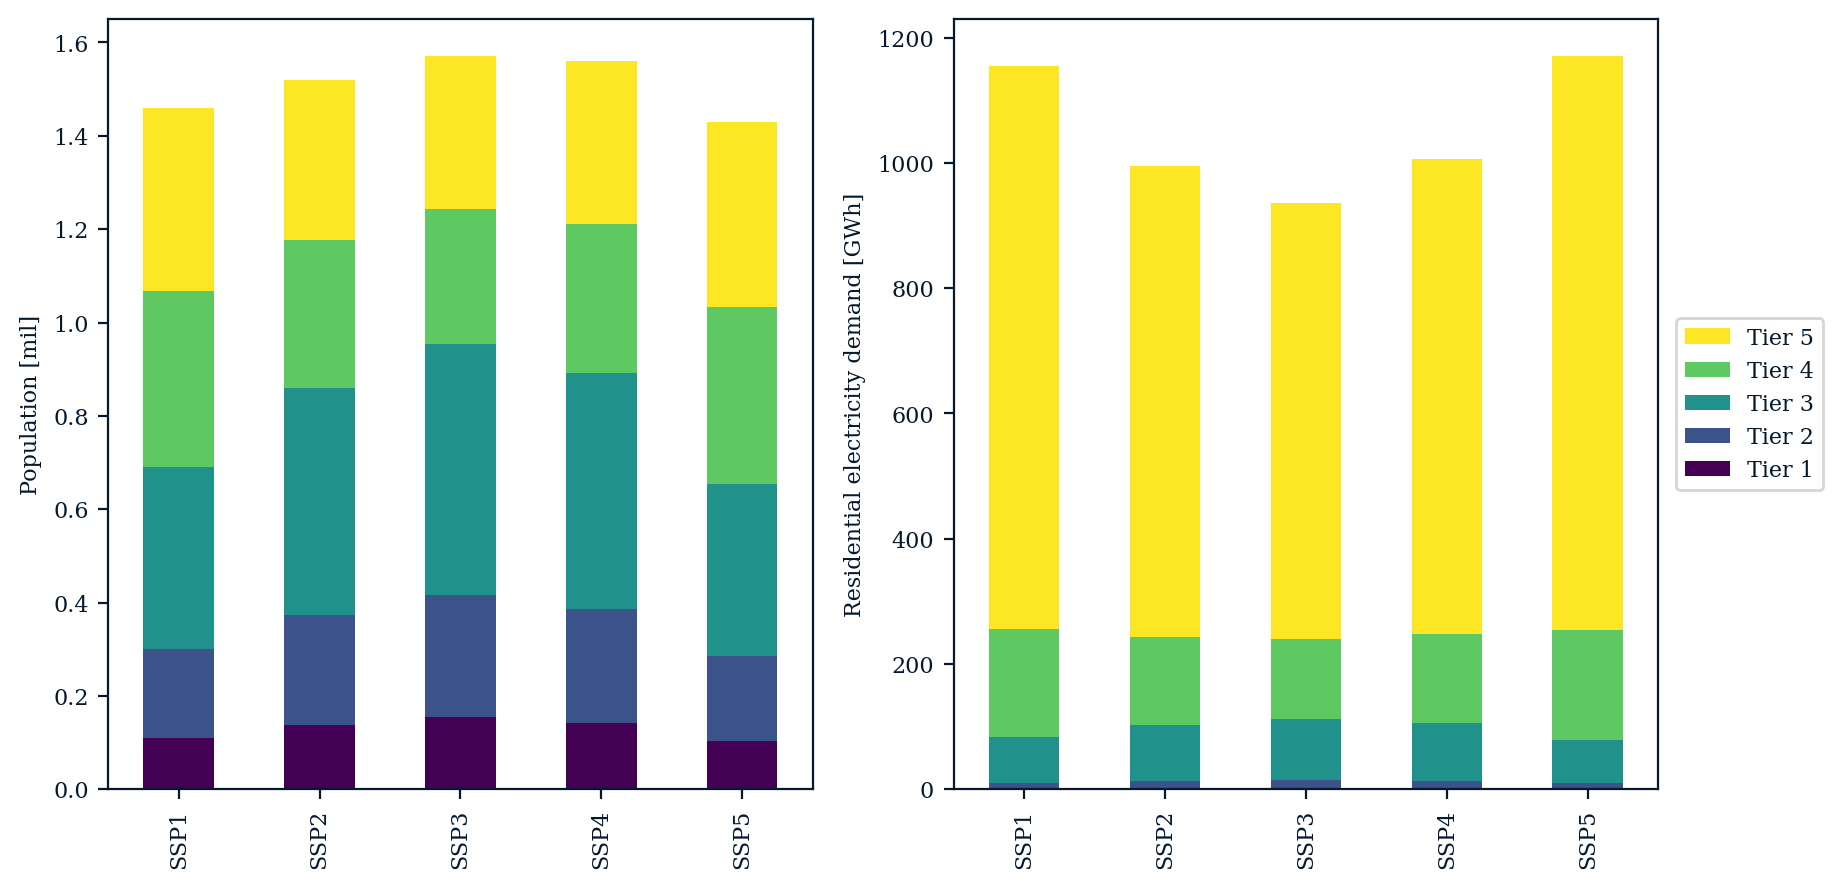

        Tier 1    Tier 2    Tier 3    Tier 4    Tier 5
SSP1  0.102424  0.178994  0.359772  0.421087  0.455118
SSP2  0.135839  0.229564  0.489295  0.360104  0.376767
SSP3  0.160287  0.272872  0.561134  0.316710  0.357510
SSP4  0.144788  0.245237  0.520222  0.359348  0.382113
SSP5  0.095174  0.169422  0.333958  0.412615  0.467720
        Tier 1     Tier 2      Tier 3      Tier 4       Tier 5
SSP1  0.805903   8.579457   67.407210  196.935162  1058.626889
SSP2  1.025008  11.108409   90.839492  162.150889   841.051660
SSP3  1.180386  13.357768  101.939197  139.680752   761.414604
SSP4  1.092075  11.957750   96.695001  161.659807   846.941798
SSP5  0.751816   8.116610   62.651526  193.995152  1086.672090


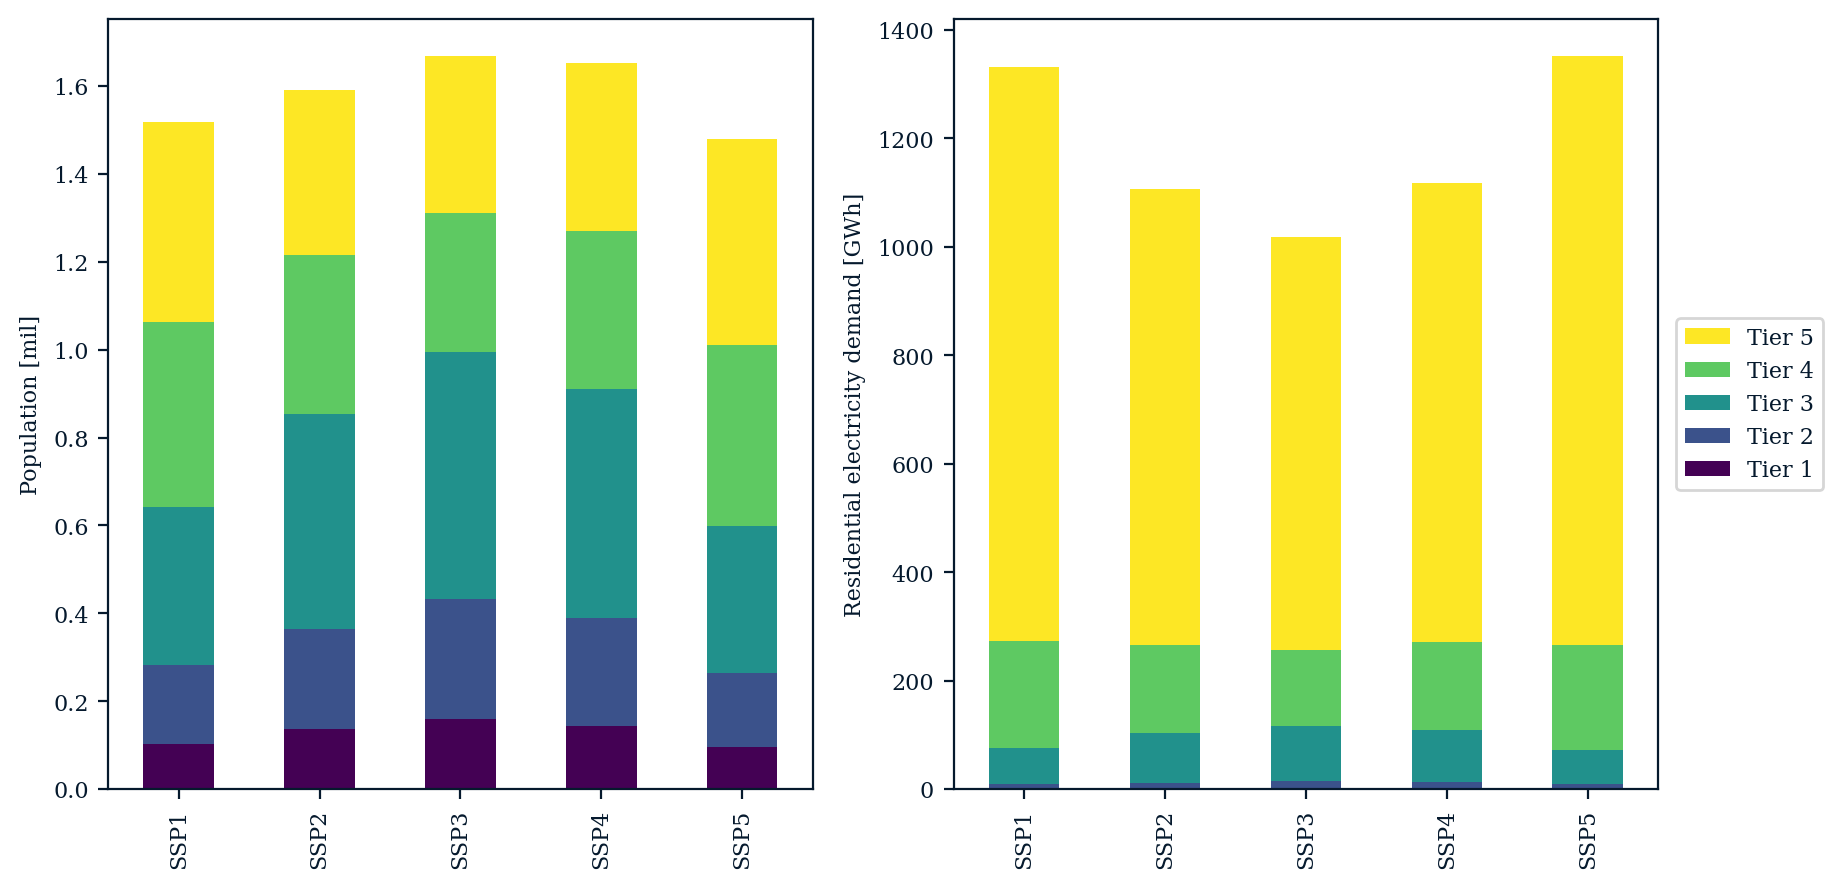

In [110]:
# Similarly for unelectrified population ONLY
for i in range(2025,2055,5): # looping over all modelled years
    unelec_pop_by_MTF = pd.DataFrame({'MTF': np.arange(1, 6)}) # empty population DataFrame, columns correspond to MTF tiers
    unelec_dem_by_MTF = pd.DataFrame({'MTF': np.arange(1, 6)}) # empty electricity demand DataFrame, columns correspond to MTF tiers
    year = str(i)
    for n in range(1,6): # looping over all SSPs (1-5)
        res_unelec_name = 'res_unelec_SSP' + str(n)
        # population in millions, summed up and grouped by MTF tiers
        unelec_pop_by_MTF['SSP'+str(n)] = locals()[res_unelec_name].groupby(year+'_MTF')[year+'_POP'].sum().values / 10 ** 6
        # total residential electricity demand in GWh, summed up and grouped by MTF tiers
        unelec_dem_by_MTF['SSP'+str(n)] = locals()[res_unelec_name].groupby(year+'_MTF')[year+'_TotElec'].sum().values / 10 ** 6
    
    # transposing DataFrames for proper plotting
    unelec_pop_by_MTF = unelec_pop_by_MTF.iloc[:,1:].transpose()
    unelec_pop_by_MTF.columns = ['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5'] # renaming columns to full name
    print(unelec_pop_by_MTF)

    unelec_dem_by_MTF = unelec_dem_by_MTF.iloc[:,1:].transpose()
    unelec_dem_by_MTF.columns = ['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4', 'Tier 5'] # renaming columns to full name
    print(unelec_dem_by_MTF)
    
    # creating 2 sub-plots for the 2 indicators
    fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(10,5))
    # 1st sub-plot: total currently unelectrified population across different SSPs, broken down by MTF tier
    unelec_pop_by_MTF.plot(kind='bar', stacked=True, cmap='viridis', ylabel='Population [mil]', ax=ax1)
    ax1.get_legend().remove() # removing legend of 1st sub-plot, only one legend is used for both plots to avoid redundancy
    # 2nd sub-plot: total estimated residential electricity demand of currently unelectrified population across different SSPs, 
    # broken down by MTF tier
    unelec_dem_by_MTF.plot(kind='bar', stacked=True, cmap='viridis', ylabel='Residential electricity demand [GWh]', ax=ax2)
    ax2.legend(bbox_to_anchor = (1.25, 0.5), loc='center right', reverse=True) # setting legend properties
    plt.rcParams['font.family'] = 'serif' # font type
    plt.rcParams['font.size'] = 8 # font size
    plt.savefig('summary_stats_byMTF_'+year+'_unelectrified.png', dpi=300) # saving output figure: file name and resolution
    plt.show()

### 7.4 Plotting detailed maps

The methods below can be adjusted to plot different indicators for different SSP narratives and transition years at different resolutions. It is advised to downsample the original 30 arcsec/1 km resolution when plotting maps for inclusion in documents and presentations to enhance visibility.

In [1]:
# defining a new function for downsampling GeoDataFrames
def downsamp(gdf, cell_size, agg_func):
    '''
    This function downsamples a GeoDataFrame to enhance visibility when plotting.
    Inputs:
        gdf (var): GeoDataFrame to downsample.
        cell_size (int or float): downsampled pixel size in CRS units.
        agg_func (str): aggregation method (e.g. sum) applied to all non-geometry columns.
        See https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html for possible aggregation functions.
    Returns:
        Downsampled GeoDataFrame (var).
    '''
    # input GeoDataFrame
    gdf = gdf
    
    # defining the size of the grid cells for downsampling
    cell_size = cell_size  # adjust this value based on your coordinate system and desired resolution

    # retrieving the bounds of the GeoDataFrame
    minx, miny, maxx, maxy = gdf.total_bounds

    # creating a grid of polygons (cells) to aggregate the higher-resolution geometries
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)
    grid_cells = [box(x, y, x + cell_size, y + cell_size) for x in x_coords for y in y_coords]

    # creating a new GeoDataFrame for the downsampled grid cells
    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)

    # performing a spatial join to aggregate the higher-resolution geometries within each grid cell
    gdf = gdf.set_geometry('centroid') # change geometry type from polygon to centroid in original GeoDataFrame
    joined = gpd.sjoin(gdf, grid, how='left', predicate='within', rsuffix='right') # join all relevant cells based on location

    joined = joined.join(grid, on='index_right', rsuffix='_right', validate='m:1') # join other cell attributes based on index
    joined = joined.set_geometry('geometry_right') # set geometry back to polygons
    joined.drop(columns=['geometry', 'centroid'], inplace=True) # drop original higher-resolution geometry columns
    
    # grouping by the grid cell index and aggregating the attributes
    aggregated = joined.dissolve(by='index_right', aggfunc=agg_func)

    # resetting the index to get a clean GeoDataFrame
    aggregated = aggregated.reset_index(drop=True)
    
    return aggregated

In [115]:
# defining input parameters for the downsampling function, can be done for as many GeoDataFrames as needed
# 1st GDF: estimated electricity demand for currently unelectrified population in 2025 under SSP1
gdf_1 = res_unelec_SSP1_2025[['geometry', 'centroid', '2025_POP', '2025_TotElec']].copy()
cell_size = 150/3600 # target cell size: approx. 5 km at equator, downsampling by a factor of 5
agg_func = 'sum' # aggregate function
res_unelec_SSP1_2025_5km = downsamp(gdf_1, cell_size, agg_func) # downsampling

# re-calculating electricity consumption per capita after downsampling total population and electricity consumption
res_unelec_SSP1_2025_5km['2025_perCapitaElec'] = res_unelec_SSP1_2025_5km['2025_TotElec'] \
                                                    / res_unelec_SSP1_2025_5km['2025_POP']
# re-classifying new electricity consumption per capita based pn MTF classes
res_unelec_SSP1_2025_5km['2025_MTF'] = pd.cut(res_unelec_SSP1_2025_5km['2025_perCapitaElec'], bins=mtf_bins,
                                                 labels=labels, right=False)

# 2nd GDF: estimated electricity demand for currently unelectrified population in 2050 under SSP1
gdf_2 = res_unelec_SSP1_2050[['geometry', 'centroid', '2050_POP', '2050_TotElec']].copy()
cell_size = 150/3600 # target cell size: approx. 5 km at equator, downsampling by a factor of 5
agg_func = 'sum' # aggregate function
res_unelec_SSP1_2050_5km = downsamp(gdf_2, cell_size, agg_func) # downsampling

# same as 1st GDF
res_unelec_SSP1_2050_5km['2050_perCapitaElec'] = res_unelec_SSP1_2050_5km['2050_TotElec'] \
                                                    / res_unelec_SSP1_2050_5km['2050_POP']
# same as 1st GDF
res_unelec_SSP1_2050_5km['2050_MTF'] = pd.cut(res_unelec_SSP1_2050_5km['2050_perCapitaElec'], bins=mtf_bins,
                                                 labels=labels, right=False)

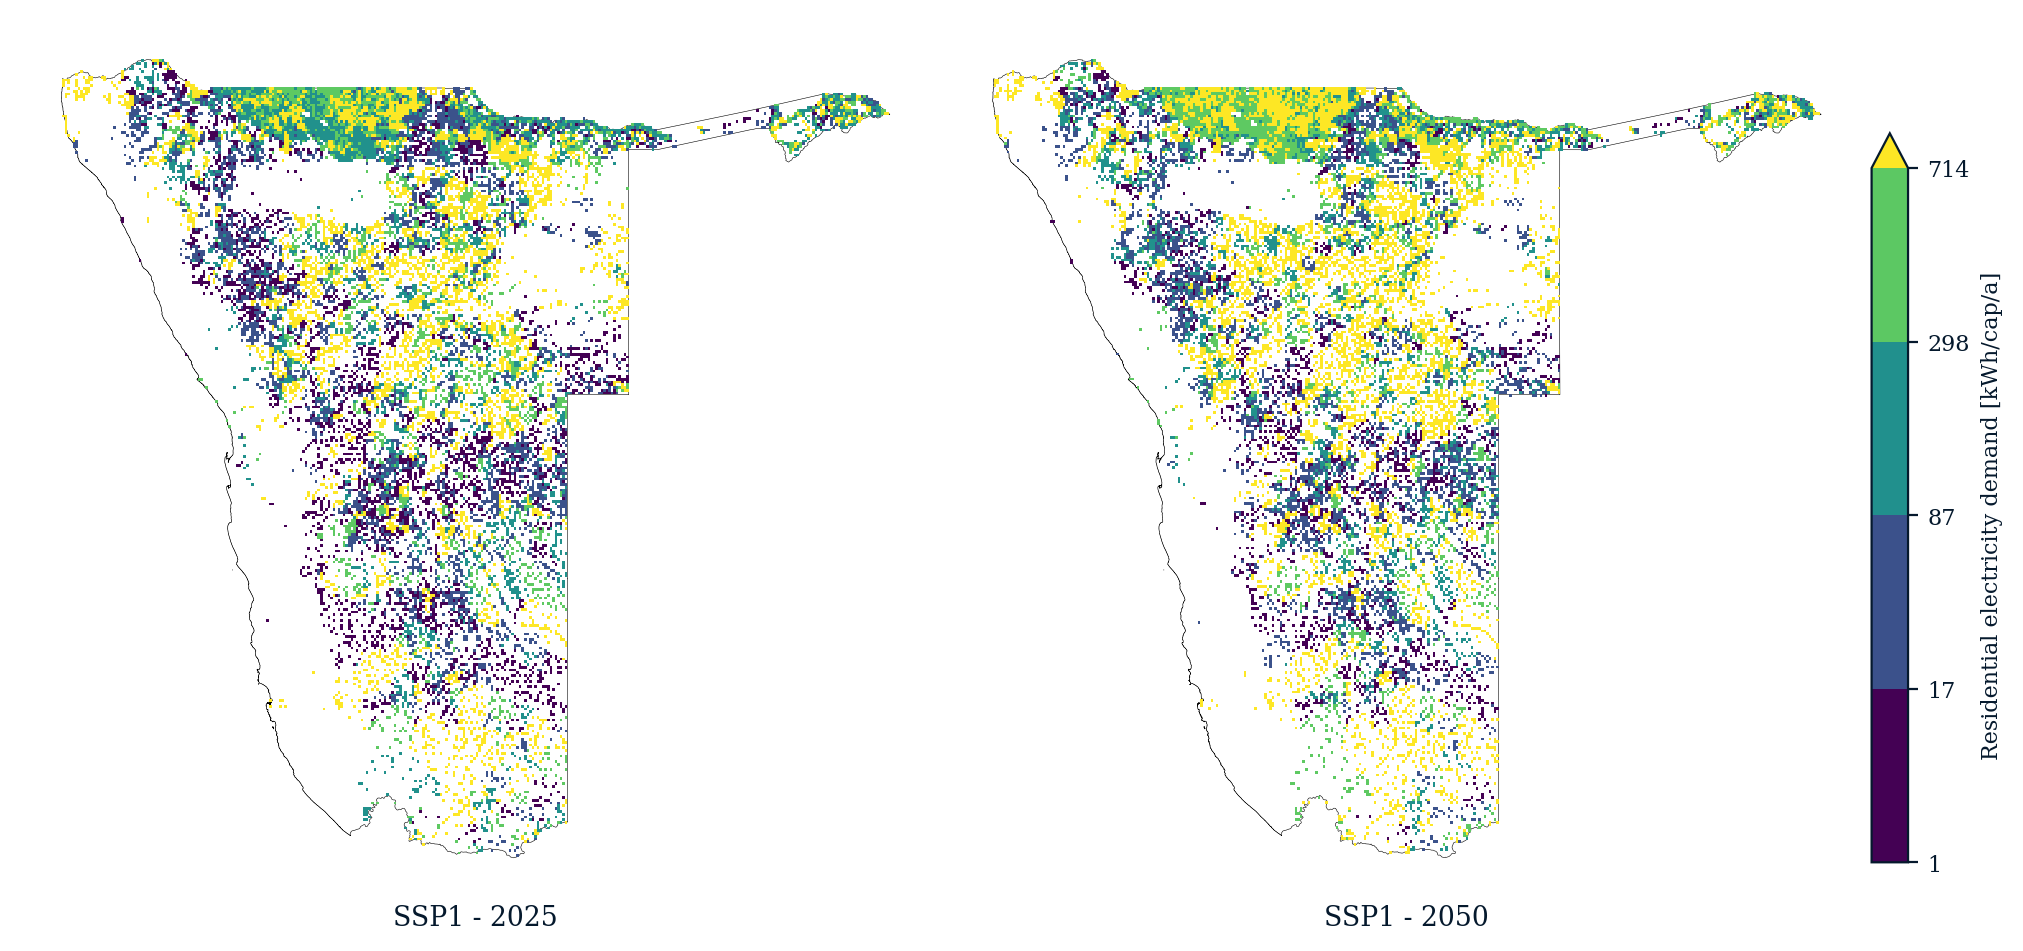

In [116]:
aggregated_1 = res_unelec_SSP1_2025_5km.copy() # copy of 1st downsampled GeoDataFrame
aggregated_2 = res_unelec_SSP1_2050_5km.copy() # copy of 2nd downsampled GeoDataFrame

# creating 2 sub-plots for the 2 GDFs
# the method below can be adjusted to include more sub-plots and/or change the plotted maps
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,12), sharex=True, sharey=True, layout='constrained')
cmap = cm.viridis # defining the colour map to be used

bins=[17, 87, 298, 714, 7140] # defining the legend bins

# 1st sub-plot: residential electricity demand per capita in 2025 under SSP1
nam_border = gpd.read_file('nam_admborders_lvl_0.shp')
nam_border.plot(facecolor='none', edgecolor='black', linewidth=0.2, ax=ax1) # plotting study region external borders
aggregated_1.plot(column='2025_perCapitaElec', ax=ax1, edgecolor='none', cmap=cmap, scheme='UserDefined',
                classification_kwds={'bins': bins}) # plotting residential electricity demand, colour-coded by MTF class
ax1.axis('off')
ax1.set_title('SSP1 - 2025', y=-0.05) # sub-plot title

# 2nd sub-plot: residential electricity demand per capita in 2050 under SSP1
nam_border.plot(facecolor='none', edgecolor='black', linewidth=0.2, ax=ax2) # plotting study region external borders
aggregated_2.plot(column='2050_perCapitaElec', ax=ax2, edgecolor='none', cmap=cmap, scheme='UserDefined',
                classification_kwds={'bins': bins}) # plotting residential electricity demand, colour-coded by MTF class
ax2.axis('off')
ax2.set_title('SSP1 - 2050', y=-0.05) # sub-plot title

# defining custom colour map intervals
bounds = [1, 17, 87, 298, 714]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max') # defining colur map bounds, maximum is left open
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) # mapping colour map to bin values
sm.set_array([])

fig.colorbar(sm, ax=ax2, fraction=0.04, pad=0.01, boundaries=bounds, ticks=bounds,
             label='Residential electricity demand [kWh/cap/a]') # setting colour bar properties

plt.rcParams['font.family'] = 'serif' # font type
plt.rcParams['font.size'] = 8 # font size

plt.savefig('demand_dist_SSP1_2550_unelectrified.png', dpi=300) # saving output figure: file name and resolution
plt.show()

### 7.5 Plotting regionally aggregated indicators

In [42]:
res_unelec_SSP1_2025.head()

,geometry,centroid,elec_stat,2025_POP,2025_INC,2025_perCapitaElec,2025_TotElec,2025_MTF
2,"POLYGON ((13.37542 -16.97542, 13.37542 -16.983...",POINT (13.37958 -16.97958),False,28.330209,150.891286,7.965104,225.653075,1
4,"POLYGON ((13.36708 -16.98375, 13.36708 -16.992...",POINT (13.37125 -16.98792),False,6.765860,7148.191679,368.615422,2494.000507,4
5,"POLYGON ((13.37542 -16.98375, 13.37542 -16.992...",POINT (13.37958 -16.98792),False,177.138132,987.536022,51.983636,9208.284140,2
6,"POLYGON ((13.38375 -16.98375, 13.38375 -16.992...",POINT (13.38792 -16.98792),False,45.652715,3831.760898,199.795814,9121.221262,3
9,"POLYGON ((13.24208 -16.99208, 13.24208 -17.000...",POINT (13.24625 -16.99625),False,2.432854,83184.193204,744.360104,1810.919261,5


In [118]:
# importing level 1 administrative regions shapefile, other levels can be used
adm_regions = gpd.read_file('nam_admborders_lvl_1.shp')
adm_regions = adm_regions[['NAME_1', 'geometry']] # keeping only required columns

year = str(2025) # defining plotted year

# aggregating 'total' statistics and re-calculating 'per capita' statistics for each administrative region
# this steps takes a long time due to the amount of high-resolution data being processed
for n in range (1,6): # looping over all SSPs
    name_input = 'res_unelec_SSP' + str(n) + '_' + year
    name_output = 'region_unelec_SSP' + str(n) + '_' + year
    
    # setting geometry to centroid instead of polygon
    locals()[name_input].set_geometry('centroid', inplace=True)
    # spatially joining original GDF to administrative regions based on location
    locals()[name_output] = gpd.sjoin(adm_regions, locals()[name_input], how='left', predicate='contains', rsuffix='right')
    # dropping unnecessary columns, change as needed
    locals()[name_output].drop(columns=['elec_stat', year+'_INC', year+'_perCapitaElec', year+'_MTF'], inplace=True)
    # summing up total population and electricity demand for each administrative region
    locals()[name_output] = locals()[name_output].groupby('NAME_1')[[year+'_POP', year+'_TotElec']].sum()
    # re-calculating electricity demand per capita based on aggregate values
    locals()[name_output][year+'_perCapitaElec'] = locals()[name_output][year+'_TotElec'] / locals()[name_output][year+'_POP']
    # re-classifying each administrative region to the MTF classes based on electricity demand per capita
    locals()[name_output][year+'_MTF'] = pd.cut(locals()[name_output][year+'_perCapitaElec'], bins=mtf_bins,
                                                     labels=labels, right=False)

In [123]:
# displaying one of the resulting DataFrames as an example
region_unelec_SSP1_2025.sort_values('2025_perCapitaElec')

,2025_POP,2025_TotElec,2025_perCapitaElec,2025_MTF
NAME_1,,,,
Kavango,156243.879440,5.836219e+07,373.532658,4
Hardap,23237.443340,9.122522e+06,392.578544,4
Oshana,74374.227078,2.975420e+07,400.060631,4
Oshikoto,159584.882029,7.596640e+07,476.025065,4
Zambezi,59129.259182,2.852515e+07,482.420209,4
Khomas,14601.202972,7.124626e+06,487.947876,4
Omusati,249951.240397,1.393766e+08,557.615036,4
Ohangwena,227821.988407,1.356624e+08,595.475533,4
Kunene,68642.364027,4.120932e+07,600.348239,4


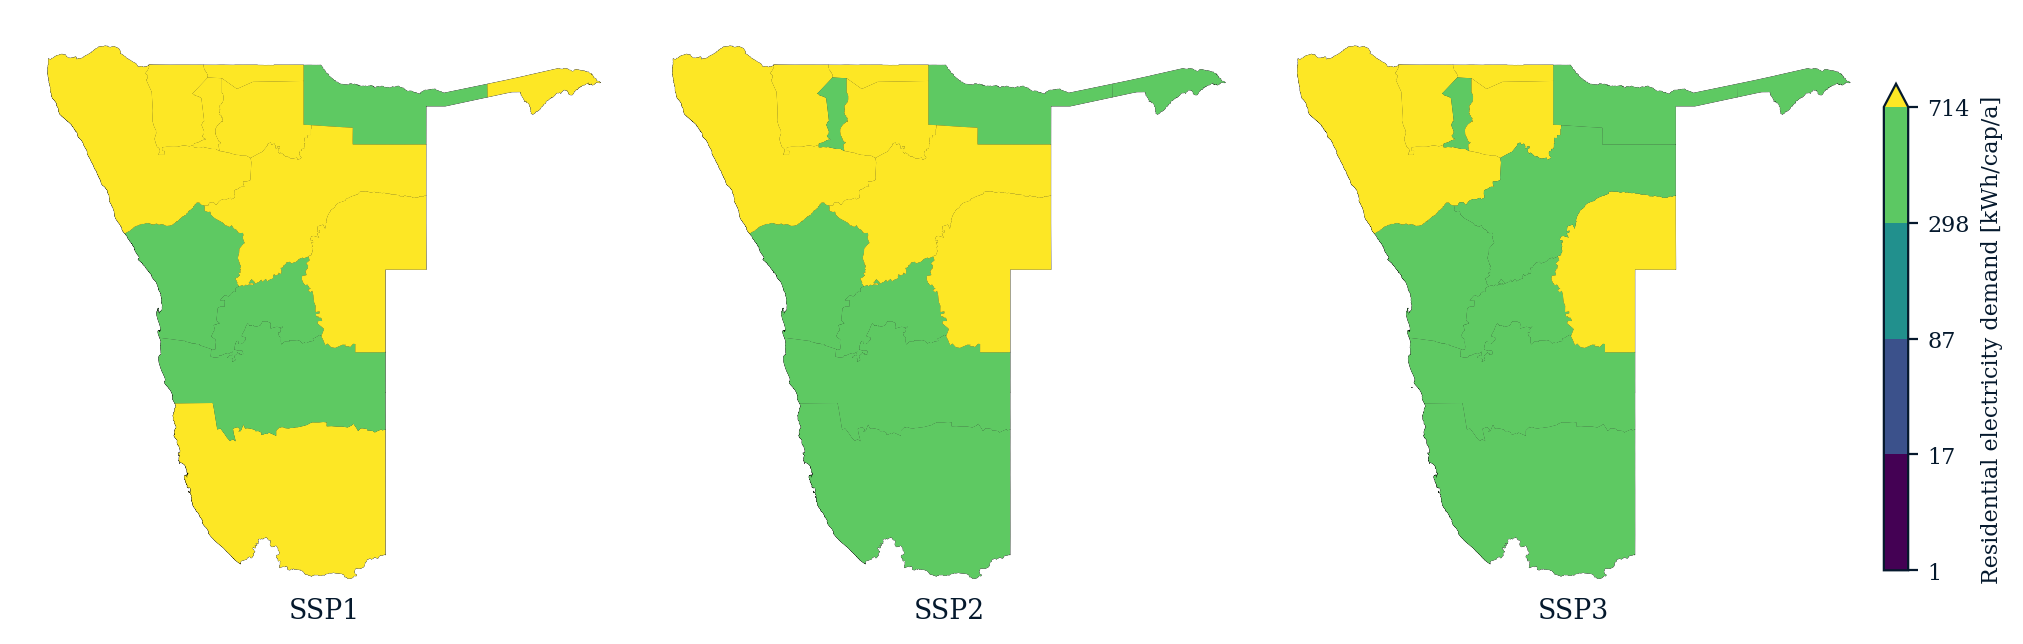

In [68]:
# plotting SSPs 1-3
# creating 3 sub-plots for the 3 SSP narratives
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,18), sharex=True, sharey=True, layout='constrained')
cmap = cm.viridis # defining the colour map to be used

# 1st sub-plot: SSP1
reg_border = gpd.read_file('nam_admborders_lvl_1.shp') 
reg_border.plot(facecolor='none', edgecolor='black', linewidth=0.2, ax=ax1) # plotting regional borders
region_elec_SSP1_2050.plot(column='2050_perCapitaElec', ax=ax1, edgecolor='none', cmap=cmap, scheme='UserDefined', classification_kwds={'bins': bins}) # plotting the residential electricity demand per capita, colour-coded by MTF class
ax1.axis('off')
ax1.set_title('SSP1', y=-0.05) # sub-plot title


# 2nd sub-plot: SSP2
reg_border.plot(facecolor='none', edgecolor='black', linewidth=0.2, ax=ax2) # plotting regional borders
region_elec_SSP2_2050.plot(column='2050_perCapitaElec', ax=ax2, edgecolor='none', cmap=cmap, scheme='UserDefined', classification_kwds={'bins': bins}) # plotting the residential electricity demand per capita, colour-coded by MTF class
ax2.axis('off')
ax2.set_title('SSP2', y=-0.05) # sub-plot title

# 3rd sub-plot: SSP3
reg_border.plot(facecolor='none', edgecolor='black', linewidth=0.2, ax=ax3) # plotting regional borders
region_elec_SSP3_2050.plot(column='2050_perCapitaElec', ax=ax3, edgecolor='none', cmap=cmap, scheme='UserDefined', classification_kwds={'bins': bins})  # plotting the residential electricity demand per capita, colour-coded by MTF class
ax3.axis('off')
ax3.set_title('SSP3', y=-0.05) # sub-plot title

# defining custom colour map intervals
bounds = [1, 17, 87, 298, 714]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max') # defining colur map bounds, maximum is left open
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) # mapping colour map to bin values
sm.set_array([])
plt.colorbar(mappable=sm, ax=ax3, fraction=0.04, pad=0.01, boundaries=bounds, ticks=bounds, anchor=(0.0,0.52),
             label='Residential electricity demand [kWh/cap/a]') # setting colour bar properties

plt.rcParams['font.family'] = 'serif' # font type
plt.rcParams['font.size'] = 8 # font size

plt.savefig('DemandDist_regional_SSP123_2050.png', dpi=300) # saving output figure: file name and resolution
plt.show()